In [ ]:
import csv
import os
import re
import random
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import nibabel as nib
from nilearn import datasets, plotting, image
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, AutoMinorLocator, MaxNLocator, FixedLocator
import sklearn
import seaborn as sns
import textwrap 
import warnings
import skbold
from scipy.stats import pearsonr
from skbold.preproc import ConfoundRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Define ConfoundRegressor with skbold

In [147]:
# Define ConfoundRegressor: skbold
def confound_regressor_skbold(features_train, features_test, confounds_train, confounds_test):
    # Scale features (train and test sets)
    scaler_features = StandardScaler()
    features_train_scaled = scaler_features.fit_transform(features_train)
    features_test_scaled = scaler_features.transform(features_test)
    
    # Scale confounds (train and test sets)
    scaler_confounds = StandardScaler()
    confounds_train_scaled = scaler_confounds.fit_transform(confounds_train)
    confounds_test_scaled = scaler_confounds.transform(confounds_test)

    # Convert full sets into np.array
    features_full_scaled_np = np.array(pd.concat([pd.DataFrame(features_train_scaled, columns = features_train.columns), pd.DataFrame(features_test_scaled, columns = features_test.columns)], axis=0))
    confounds_full_scaled_np = np.array(pd.concat([pd.DataFrame(confounds_train_scaled, columns = confounds_train.columns), pd.DataFrame(confounds_test_scaled, columns = confounds_test.columns)], axis=0))
    
    # Define ConfoundRegressor on a FULL set (train and test)
    cfr = ConfoundRegressor(confound=confounds_full_scaled_np, X=features_full_scaled_np)
    features_train_corrected = cfr.fit_transform(features_train_scaled)
    features_test_corrected = cfr.transform(features_test_scaled)


    return features_train_corrected, features_test_corrected, features_train_scaled, features_test_scaled, scaler_features

Alternatively, if for some reason *skbold* does not work, a similar result can be obtained by applying LinearRegression model - they give IDENTICAL results

In [177]:
# Define ConfoundRegressor: Linear Model
def confound_regressor(features_train, features_test, confounds_train, confounds_test):
    from sklearn.linear_model import LinearRegression

    scaler_features = StandardScaler()
    features_train = scaler_features.fit_transform(features_train)
    features_test = scaler_features.transform(features_test)
        
    # Scale confounds (train and test sets)
    scaler_confounds = StandardScaler()
    confounds_train = scaler_confounds.fit_transform(confounds_train)
    confounds_test = scaler_confounds.transform(confounds_test)
        
    model = LinearRegression()
    model.fit(confounds_train, features_train)
    features_train_pred = model.predict(confounds_train)
    features_train_res = features_train - features_train_pred

    features_test_pred = model.predict(confounds_test)
    features_test_res = features_test - features_test_pred

    return features_train_res, features_test_res, features_train, features_test, scaler_features

## Upload and prepare T1w files

In [ ]:
struct_fast = pd.read_csv('/PLS/brain/t1/t1_idp/struct_fast_names_nona.csv')
struct_sub_first = pd.read_csv('/PLS/brain/t1/t1_idp/struct_sub_first_names_nona.csv')
struct_aseg_mean_intensity = pd.read_csv('/PLS/brain/t1/t1_idp/struct_aseg_mean_intensity_names_nona.csv')
struct_aseg_volume = pd.read_csv('/PLS/brain/t1/t1_idp/struct_aseg_volume_names_nona.csv')
struct_ba_exvivo_area = pd.read_csv('/PLS/brain/t1/t1_idp/struct_ba_exvivo_area_names_nona.csv')
struct_ba_exvivo_mean_thickness = pd.read_csv('/PLS/brain/t1/t1_idp/struct_ba_exvivo_mean_thickness_names_nona.csv')
struct_ba_exvivo_volume = pd.read_csv('/PLS/brain/t1/t1_idp/struct_ba_exvivo_volume_names_nona.csv')
struct_a2009s_area = pd.read_csv('/PLS/brain/t1/t1_idp/struct_a2009s_area_names_nona.csv')
struct_a2009s_mean_thickness = pd.read_csv('/PLS/brain/t1/t1_idp/struct_a2009s_mean_thickness_names_nona.csv')
struct_a2009s_volume = pd.read_csv('/PLS/brain/t1/t1_idp/struct_a2009s_volume_names_nona.csv')
struct_dkt_area = pd.read_csv('/PLS/brain/t1/t1_idp/struct_dkt_area_names_nona.csv')
struct_dkt_mean_thickness = pd.read_csv('/PLS/brain/t1/t1_idp/struct_dkt_mean_thickness_names_nona.csv')
struct_dkt_volume = pd.read_csv('/PLS/brain/t1/t1_idp/struct_dkt_volume_names_nona.csv')
struct_desikan_gw = pd.read_csv('/PLS/brain/t1/t1_idp/struct_desikan_gw_names_nona.csv')
struct_desikan_pial = pd.read_csv('/PLS/brain/t1/t1_idp/struct_desikan_pial_names_nona.csv')
struct_desikan_white_area = pd.read_csv('/PLS/brain/t1/t1_idp/struct_desikan_white_area_names_nona.csv')
struct_desikan_white_mean_thickness = pd.read_csv('/PLS/brain/t1/t1_idp/struct_desikan_white_mean_thickness_names_nona.csv')
struct_desikan_white_volume = pd.read_csv('/PLS/brain/t1/t1_idp/struct_desikan_white_volume_names_nona.csv')
struct_subsegmentation = pd.read_csv('/PLS/brain/t1/t1_idp/struct_subsegmentation_names_nona.csv')

In [3]:
modalities = ['struct_fast', 'struct_sub_first', 'struct_aseg_mean_intensity', 'struct_aseg_volume', 'struct_ba_exvivo_area', 
          'struct_ba_exvivo_mean_thickness', 'struct_ba_exvivo_volume', 'struct_a2009s_area', 'struct_a2009s_mean_thickness', 'struct_a2009s_volume',
           'struct_dkt_area', 'struct_dkt_mean_thickness', 'struct_dkt_volume', 'struct_desikan_gw', 'struct_desikan_pial',
           'struct_desikan_white_area', 'struct_desikan_white_mean_thickness', 'struct_desikan_white_volume', 'struct_subsegmentation']

Some columns have 'Field ID...' in their names - remove them

In [ ]:
folder_path = '/PLS/brain/t1/t1_idp/'
def clean_dataframe_columns(modality):
    # Load the data frame
    df = pd.read_csv(f"{folder_path}{modality}_names_nona.csv")

    # Rename columns if they contain 'Field ID...'
    #df.columns = [col.replace('Field ID', '').strip() for col in df.columns]
    df.columns = [re.sub(r'\(Field ID: \d+\)', '', col).strip() for col in df.columns]
    
    df.to_csv(f"{folder_path}{modality}_renamed.csv", index=False)
    print(f"Cleaned columns for {modality} and saved to {modality}_renamed.csv")

# Iterate over each modality and clean the columns
for modality in modalities:
    clean_dataframe_columns(modality)

# PLS

## Prepare files

In [ ]:
confounds = pd.read_csv('/PLS/brain/t1/t1_idp/struct_conf_full_dummy.csv')

############## 1
print('Started: Uploading')

for modality in modalities:

    file = pd.read_csv(f'/PLS/brain/t1/t1_idp/{modality}_renamed.csv')
    #modality_data = globals()[modality]

    folds = ["0", "1", "2", "3", "4"]
    
    # Match confounds to MRI
    print('Started: Match confounds to brain data')
    conf_to_brain_match = pd.merge(confounds, file['eid'], on='eid')
    brain_to_conf_match = pd.merge(conf_to_brain_match['eid'], file, on='eid')

    for fold in folds:
        train_id = pd.read_csv(f'/g_factor_5_folds_python/fold_{fold}/train_id_fold_{fold}.csv')
        test_id = pd.read_csv(f'/g_factor_5_folds_python/fold_{fold}/test_id_fold_{fold}.csv')
        
        # Upload g-factor with ID
        g_train_full = pd.read_csv(f'/PLS/g_factor/g_train_with_id_fold_{fold}.csv')
        g_test_full = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv')

    
        # Match brain data to cognitive data
        brain_train, brain_test, brain_train_id, brain_test_id = pd.merge(brain_to_conf_match, train_id, on='eid').drop(columns=['eid']), pd.merge(brain_to_conf_match, test_id, on='eid').drop(columns=['eid']), pd.merge(brain_to_conf_match, train_id, on='eid')['eid'], pd.merge(brain_to_conf_match, test_id, on='eid')['eid']

        brain_train.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_fold_{fold}.csv', index=False)
        brain_test.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_test_fold_{fold}.csv', index=False)
        brain_train_id.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_id_fold_{fold}.csv', index=False)
        brain_test_id.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_test_id_fold_{fold}.csv', index=False)
        
        ############## 2
        print(f'Matching confounds to {modality} fold {fold}')
        
        # Match confounds to MRI
        brain_conf_train, brain_conf_test = pd.merge(conf_to_brain_match, brain_train_id, on='eid').drop(columns=['eid']), pd.merge(conf_to_brain_match, brain_test_id, on='eid').drop(columns=['eid'])
        brain_conf_train.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_conf_train_fold_{fold}.csv', index=False)
        brain_conf_test.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_conf_test_fold_{fold}.csv', index=False)
        
        ############## 3
        print(f'Matching g-factor to {modality}')
        
        # Match g-factor back to MRI
        g_train, g_test, g_train_id, g_test_id = pd.merge(g_train_full, brain_train_id, on='eid').drop(columns=['eid']), pd.merge(g_test_full, brain_test_id, on='eid').drop(columns=['eid']), pd.merge(g_train_full, brain_train_id, on='eid')['eid'], pd.merge(g_test_full, brain_test_id, on='eid')['eid']
        g_train.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_{modality}_matched_fold_{fold}.csv', index=False)
        g_test.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_test_{modality}_matched_fold_{fold}.csv', index=False)

        g_train_id.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_id_{modality}_matched_fold_{fold}.csv', index=False)
        g_test_id.to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_test_id_{modality}_matched_fold_{fold}.csv', index=False)

## Run PLS

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

############## 1
seed = 42

for modality in modalities:
    
    folds = ["0", "1", "2", "3", "4"]
    pls_result = {}
    

    for fold in folds:
        brain_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_fold_{fold}.csv')
        brain_test = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_test_fold_{fold}.csv')
        brain_conf_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_conf_train_fold_{fold}.csv')
        brain_conf_test = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_conf_test_fold_{fold}.csv')
        g_train_id = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_id_{modality}_matched_fold_{fold}.csv')
        g_test_id = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_test_id_{modality}_matched_fold_{fold}.csv')
        g_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_{modality}_matched_fold_{fold}.csv')
        g_test = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_test_{modality}_matched_fold_{fold}.csv')
       
        # Apply ConfoundRegressor

        features_train_corr, features_test_corr, features_train, features_test, scaler_features = confound_regressor(brain_train, brain_test, brain_conf_train, brain_conf_test)

        pd.DataFrame(features_train_corr, columns = brain_train.columns).to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_corr_{fold}.csv', index=False)
        pd.DataFrame(features_test_corr, columns = brain_test.columns).to_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_test_corr_{fold}.csv', index=False)
        
        with open(f'/PLS/brain/t1/fold_{fold}/suppl/scaler_features_{modality}_fold_{fold}.pkl', "wb") as f:
            pickle.dump(scaler_features, f)

        # Initiate and run PLS
        parameters = {'n_components': range(1, features_train_corr.shape[1]+1, 1)}
        pls = PLSRegression()
        model = GridSearchCV(pls, parameters, scoring = 'neg_mean_absolute_error', cv=KFold(10, shuffle = True, random_state=seed), verbose=4, n_jobs = 8)
        
        
        print("Fitting PLS")
        model.fit(features_train_corr, np.array(g_train))
        
        print(f'Model parameters for fold {fold}:', model.cv_results_['params'])
        print(f'Mean test score for fold {fold}:', model.cv_results_['mean_test_score'])
        print(f'Rank test score for fold {fold}:', model.cv_results_['rank_test_score'])
        print(model)
        
        print(f'Saving PLS model for {modality} fold {fold}')
        with open(f'/PLS/brain/t1/fold_{fold}/models/{modality}_model_fold_{fold}.pkl', "wb") as f:
            pickle.dump(model, f)
            
        print(f'Best params in fold {fold} = ', model.best_params_)
        print(f'Best score (neg_mean_absolute_error) in fold {fold} = ', model.best_score_)
            
        # Predict the values
        print(f'Predicting & saving g_test for {modality} fold {fold}')
        g_pred_test = model.predict(np.array(features_test_corr))
        pd.DataFrame(g_pred_test, columns=['g predicted test']).to_csv(f'/PLS/brain/t1/fold_{fold}/g_pred/{modality}_g_pred_test_fold_{fold}.csv')

        g_pred_test_with_id = pd.concat([g_test_id.astype(int), pd.DataFrame(g_pred_test, columns=['g predicted test'])], axis=1).to_csv(f'/PLS/brain/t1/fold_{fold}/g_pred/{modality}_g_pred_test_id_fold_{fold}.csv')

        
        print(f'Predicting & saving g_train for {modality} fold {fold}')
        g_pred_train = model.predict(np.array(features_train_corr))
        pd.DataFrame(g_pred_train, columns=['g predicted train']).to_csv(f'/PLS/brain/t1/fold_{fold}/g_pred/{modality}_g_pred_train_fold_{fold}.csv')
        

        g_pred_train_with_id = pd.concat([g_train_id.astype(int), pd.DataFrame(g_pred_train, columns=['g predicted train'])], axis=1).to_csv(f'/PLS/brain/t1/fold_{fold}/g_pred/{modality}_g_pred_train_id_fold_{fold}.csv')
        
            
        print(f"Fold = {fold}")
        print("----------")
        print("MSE = ", mean_squared_error(np.array(g_test)[:,0], g_pred_test[:,0]))
        print("MAE = ", mean_absolute_error(np.array(g_test)[:,0], g_pred_test[:,0]))
        print("R2 = ", r2_score(np.array(g_test)[:,0], g_pred_test[:,0]))
        print("Pearson's r = ", pearsonr(np.array(g_test)[:,0], g_pred_test[:,0]))
        print("----------")
            
        pls_result['fold'] = fold
        pls_result['modality'] = modality
        pls_result['n_components'] = model.best_params_
        pls_result['MSE'] = mean_squared_error(np.array(g_test)[:,0], g_pred_test[:,0])
        pls_result['MAE'] = mean_absolute_error(np.array(g_test)[:,0], g_pred_test[:,0])
        pls_result['R2'] = r2_score(np.array(g_test)[:,0], g_pred_test[:,0])
        pls_result['Pearson r'] = pearsonr(np.array(g_test)[:,0], g_pred_test[:,0])
            
        with open(f'/PLS/brain/t1/fold_{fold}/models/{modality}_fold_{fold}_PLS_result.csv', 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=pls_result.keys())
            writer.writerow(pls_result)
            
        pls_result.clear()
        
        corr, pval = stats.pearsonr(np.squeeze(np.array(g_test)), np.squeeze(g_pred_test))
        r2 = r2_score(np.squeeze(np.array(g_test)), np.squeeze(g_pred_test))
        mse = mean_squared_error(np.squeeze(np.array(g_test)), np.squeeze(g_pred_test))
        pd.DataFrame([modality, fold, corr, pval, r2, mse, model.best_params_], index=['Modality', 'Fold', 'Correlation', 'P-value', 'R2', 'MSE', 'n components'], columns=['Values']).to_csv(f'/PLS/brain/t1/fold_{fold}/models/{modality}_fold_{fold}_full_result.csv')

Started: Uploading
Fitting PLS
Fitting 10 folds for each of 139 candidates, totalling 1390 fits
[CV 8/10] END ..................n_components=1;, score=-0.555 total time=   0.1s
[CV 7/10] END ..................n_components=1;, score=-0.571 total time=   0.1s
[CV 6/10] END ..................n_components=1;, score=-0.535 total time=   0.1s
[CV 2/10] END ..................n_components=1;, score=-0.543 total time=   0.1s
[CV 5/10] END ..................n_components=1;, score=-0.549 total time=   0.1s
[CV 3/10] END ..................n_components=1;, score=-0.548 total time=   0.1s
[CV 4/10] END ..................n_components=1;, score=-0.562 total time=   0.1s
[CV 1/10] END ..................n_components=1;, score=-0.554 total time=   0.1s
[CV 9/10] END ..................n_components=1;, score=-0.543 total time=   0.1s
[CV 10/10] END .................n_components=1;, score=-0.543 total time=   0.1s
[CV 1/10] END ..................n_components=2;, score=-0.552 total time=   0.1s
[CV 5/10] END

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=71;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=71;, score=-0.562 total time=   2.3s
[CV 4/10] END .................n_components=71;, score=-0.540 total time=   2.3s
[CV 7/10] END .................n_components=71;, score=-0.553 total time=   2.1s
[CV 8/10] END .................n_components=71;, score=-0.563 total time=   2.0s
[CV 5/10] END .................n_components=71;, score=-0.567 total time=   2.4s
[CV 6/10] END .................n_components=71;, score=-0.555 total time=   2.4s
[CV 9/10] END .................n_components=71;, score=-0.558 total time=   2.7s
[CV 10/10] END ................n_components=71;, score=-0.563 total time=   2.3s
[CV 1/10] END .................n_components=72;, score=-0.543 total time=   2.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=72;, score=-0.567 total time=   2.2s
[CV 3/10] END .................n_components=72;, score=-0.562 total time=   2.1s
[CV 4/10] END .................n_components=72;, score=-0.540 total time=   2.1s
[CV 5/10] END .................n_components=72;, score=-0.567 total time=   2.2s
[CV 6/10] END .................n_components=72;, score=-0.555 total time=   2.7s
[CV 8/10] END .................n_components=72;, score=-0.563 total time=   2.3s
[CV 9/10] END .................n_components=72;, score=-0.558 total time=   2.3s
[CV 7/10] END .................n_components=72;, score=-0.553 total time=   2.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=72;, score=-0.563 total time=   2.4s
[CV 1/10] END .................n_components=73;, score=-0.543 total time=   2.1s
[CV 2/10] END .................n_components=73;, score=-0.567 total time=   2.1s
[CV 3/10] END .................n_components=73;, score=-0.562 total time=   2.3s
[CV 5/10] END .................n_components=73;, score=-0.567 total time=   2.2s
[CV 4/10] END .................n_components=73;, score=-0.540 total time=   2.8s
[CV 6/10] END .................n_components=73;, score=-0.555 total time=   2.4s
[CV 9/10] END .................n_components=73;, score=-0.558 total time=   2.0s
[CV 10/10] END ................n_components=73;, score=-0.563 total time=   2.1s
[CV 8/10] END .................n_components=73;, score=-0.563 total time=   2.2s
[CV 7/10] END .................n_components=73;, score=-0.553 total time=   2.8s
[CV 1/10] END .................n_components=74;, score=-0.543 total time=   2.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=74;, score=-0.567 total time=   2.3s
[CV 4/10] END .................n_components=74;, score=-0.540 total time=   2.2s
[CV 5/10] END .................n_components=74;, score=-0.567 total time=   2.1s
[CV 3/10] END .................n_components=74;, score=-0.562 total time=   2.7s
[CV 6/10] END .................n_components=74;, score=-0.555 total time=   2.2s
[CV 7/10] END .................n_components=74;, score=-0.553 total time=   2.2s
[CV 8/10] END .................n_components=74;, score=-0.563 total time=   2.6s
[CV 9/10] END .................n_components=74;, score=-0.558 total time=   2.4s
[CV 10/10] END ................n_components=74;, score=-0.563 total time=   2.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=75;, score=-0.567 total time=   2.2s
[CV 1/10] END .................n_components=75;, score=-0.543 total time=   2.4s
[CV 5/10] END .................n_components=75;, score=-0.567 total time=   2.2s
[CV 4/10] END .................n_components=75;, score=-0.540 total time=   2.3s
[CV 3/10] END .................n_components=75;, score=-0.562 total time=   2.5s
[CV 6/10] END .................n_components=75;, score=-0.555 total time=   2.5s
[CV 7/10] END .................n_components=75;, score=-0.553 total time=   2.4s
[CV 8/10] END .................n_components=75;, score=-0.563 total time=   2.1s
[CV 9/10] END .................n_components=75;, score=-0.558 total time=   2.3s
[CV 10/10] END ................n_components=75;, score=-0.563 total time=   2.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=76;, score=-0.567 total time=   2.2s
[CV 1/10] END .................n_components=76;, score=-0.543 total time=   2.3s
[CV 3/10] END .................n_components=76;, score=-0.562 total time=   2.5s
[CV 5/10] END .................n_components=76;, score=-0.567 total time=   2.4s
[CV 6/10] END .................n_components=76;, score=-0.555 total time=   2.2s
[CV 4/10] END .................n_components=76;, score=-0.540 total time=   2.8s
[CV 7/10] END .................n_components=76;, score=-0.553 total time=   2.2s
[CV 9/10] END .................n_components=76;, score=-0.558 total time=   2.3s
[CV 10/10] END ................n_components=76;, score=-0.563 total time=   2.3s
[CV 8/10] END .................n_components=76;, score=-0.563 total time=   2.9s
[CV 1/10] END .................n_components=77;, score=-0.543 total time=   2.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=77;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=77;, score=-0.562 total time=   2.4s
[CV 5/10] END .................n_components=77;, score=-0.567 total time=   2.1s
[CV 4/10] END .................n_components=77;, score=-0.540 total time=   2.7s
[CV 6/10] END .................n_components=77;, score=-0.555 total time=   2.1s
[CV 7/10] END .................n_components=77;, score=-0.553 total time=   2.4s
[CV 8/10] END .................n_components=77;, score=-0.563 total time=   2.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END .................n_components=77;, score=-0.558 total time=   2.8s
[CV 2/10] END .................n_components=78;, score=-0.567 total time=   2.1s
[CV 10/10] END ................n_components=77;, score=-0.563 total time=   2.5s
[CV 1/10] END .................n_components=78;, score=-0.543 total time=   2.4s
[CV 4/10] END .................n_components=78;, score=-0.540 total time=   2.2s
[CV 3/10] END .................n_components=78;, score=-0.562 total time=   2.6s
[CV 5/10] END .................n_components=78;, score=-0.567 total time=   2.5s
[CV 8/10] END .................n_components=78;, score=-0.563 total time=   2.1s
[CV 6/10] END .................n_components=78;, score=-0.555 total time=   2.7s
[CV 10/10] END ................n_components=78;, score=-0.563 total time=   2.3s
[CV 9/10] END .................n_components=78;, score=-0.558 total time=   2.5s
[CV 7/10] END .................n_components=78;, score=-0.553 total time=   2.8s
[CV 1/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=79;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=79;, score=-0.562 total time=   2.7s
[CV 4/10] END .................n_components=79;, score=-0.540 total time=   2.1s
[CV 6/10] END .................n_components=79;, score=-0.555 total time=   2.2s
[CV 5/10] END .................n_components=79;, score=-0.567 total time=   2.5s
[CV 7/10] END .................n_components=79;, score=-0.553 total time=   2.6s
[CV 9/10] END .................n_components=79;, score=-0.558 total time=   2.4s
[CV 8/10] END .................n_components=79;, score=-0.563 total time=   2.8s
[CV 10/10] END ................n_components=79;, score=-0.563 total time=   2.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=80;, score=-0.567 total time=   2.2s
[CV 1/10] END .................n_components=80;, score=-0.543 total time=   2.8s
[CV 3/10] END .................n_components=80;, score=-0.562 total time=   2.2s
[CV 4/10] END .................n_components=80;, score=-0.540 total time=   3.0s
[CV 5/10] END .................n_components=80;, score=-0.567 total time=   2.7s
[CV 6/10] END .................n_components=80;, score=-0.555 total time=   2.5s
[CV 7/10] END .................n_components=80;, score=-0.553 total time=   2.5s
[CV 8/10] END .................n_components=80;, score=-0.563 total time=   2.7s
[CV 9/10] END .................n_components=80;, score=-0.558 total time=   2.6s
[CV 1/10] END .................n_components=81;, score=-0.543 total time=   2.3s
[CV 10/10] END ................n_components=80;, score=-0.563 total time=   2.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 4/10] END .................n_components=81;, score=-0.540 total time=   2.4s
[CV 2/10] END .................n_components=81;, score=-0.567 total time=   2.7s
[CV 5/10] END .................n_components=81;, score=-0.567 total time=   2.5s
[CV 3/10] END .................n_components=81;, score=-0.562 total time=   2.7s
[CV 6/10] END .................n_components=81;, score=-0.555 total time=   2.6s
[CV 8/10] END .................n_components=81;, score=-0.563 total time=   2.2s
[CV 7/10] END .................n_components=81;, score=-0.553 total time=   2.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END .................n_components=81;, score=-0.558 total time=   3.1s
[CV 1/10] END .................n_components=82;, score=-0.543 total time=   2.6s
[CV 2/10] END .................n_components=82;, score=-0.567 total time=   2.5s
[CV 10/10] END ................n_components=81;, score=-0.563 total time=   3.1s
[CV 3/10] END .................n_components=82;, score=-0.562 total time=   3.2s
[CV 5/10] END .................n_components=82;, score=-0.567 total time=   2.4s
[CV 4/10] END .................n_components=82;, score=-0.540 total time=   2.6s
[CV 6/10] END .................n_components=82;, score=-0.555 total time=   2.9s
[CV 7/10] END .................n_components=82;, score=-0.553 total time=   2.7s
[CV 9/10] END .................n_components=82;, score=-0.558 total time=   2.8s
[CV 8/10] END .................n_components=82;, score=-0.563 total time=   2.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=82;, score=-0.563 total time=   2.7s
[CV 2/10] END .................n_components=83;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=83;, score=-0.562 total time=   2.8s
[CV 1/10] END .................n_components=83;, score=-0.543 total time=   2.8s
[CV 4/10] END .................n_components=83;, score=-0.540 total time=   2.9s
[CV 5/10] END .................n_components=83;, score=-0.567 total time=   3.0s
[CV 6/10] END .................n_components=83;, score=-0.555 total time=   2.9s
[CV 9/10] END .................n_components=83;, score=-0.558 total time=   2.4s
[CV 8/10] END .................n_components=83;, score=-0.563 total time=   2.6s
[CV 7/10] END .................n_components=83;, score=-0.553 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=84;, score=-0.543 total time=   3.0s
[CV 10/10] END ................n_components=83;, score=-0.563 total time=   3.0s
[CV 2/10] END .................n_components=84;, score=-0.567 total time=   2.7s
[CV 3/10] END .................n_components=84;, score=-0.562 total time=   2.9s
[CV 5/10] END .................n_components=84;, score=-0.567 total time=   2.6s
[CV 6/10] END .................n_components=84;, score=-0.555 total time=   2.6s
[CV 4/10] END .................n_components=84;, score=-0.540 total time=   3.0s
[CV 7/10] END .................n_components=84;, score=-0.553 total time=   3.1s
[CV 8/10] END .................n_components=84;, score=-0.563 total time=   2.8s
[CV 9/10] END .................n_components=84;, score=-0.558 total time=   3.0s
[CV 10/10] END ................n_components=84;, score=-0.563 total time=   2.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=85;, score=-0.567 total time=   2.7s
[CV 1/10] END .................n_components=85;, score=-0.543 total time=   2.9s
[CV 3/10] END .................n_components=85;, score=-0.562 total time=   2.7s
[CV 4/10] END .................n_components=85;, score=-0.540 total time=   3.0s
[CV 5/10] END .................n_components=85;, score=-0.567 total time=   3.1s
[CV 6/10] END .................n_components=85;, score=-0.555 total time=   3.3s
[CV 7/10] END .................n_components=85;, score=-0.553 total time=   3.2s
[CV 8/10] END .................n_components=85;, score=-0.563 total time=   3.2s
[CV 9/10] END .................n_components=85;, score=-0.558 total time=   2.6s
[CV 10/10] END ................n_components=85;, score=-0.563 total time=   2.7s
[CV 1/10] END .................n_components=86;, score=-0.543 total time=   2.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=86;, score=-0.567 total time=   2.9s
[CV 3/10] END .................n_components=86;, score=-0.562 total time=   3.2s
[CV 4/10] END .................n_components=86;, score=-0.540 total time=   3.1s
[CV 5/10] END .................n_components=86;, score=-0.567 total time=   3.0s
[CV 6/10] END .................n_components=86;, score=-0.555 total time=   2.9s
[CV 7/10] END .................n_components=86;, score=-0.553 total time=   2.6s
[CV 8/10] END .................n_components=86;, score=-0.563 total time=   2.7s
[CV 9/10] END .................n_components=86;, score=-0.558 total time=   3.2s
[CV 10/10] END ................n_components=86;, score=-0.563 total time=   2.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 4/10] END .................n_components=87;, score=-0.540 total time=   2.6s
[CV 1/10] END .................n_components=87;, score=-0.543 total time=   3.3s
[CV 2/10] END .................n_components=87;, score=-0.567 total time=   3.3s
[CV 3/10] END .................n_components=87;, score=-0.562 total time=   3.3s
[CV 6/10] END .................n_components=87;, score=-0.555 total time=   2.7s
[CV 5/10] END .................n_components=87;, score=-0.567 total time=   2.9s
[CV 7/10] END .................n_components=87;, score=-0.553 total time=   2.8s
[CV 8/10] END .................n_components=87;, score=-0.563 total time=   2.7s
[CV 9/10] END .................n_components=87;, score=-0.558 total time=   2.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=87;, score=-0.563 total time=   2.9s
[CV 2/10] END .................n_components=88;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=88;, score=-0.562 total time=   2.6s
[CV 1/10] END .................n_components=88;, score=-0.543 total time=   2.9s
[CV 4/10] END .................n_components=88;, score=-0.540 total time=   2.8s
[CV 5/10] END .................n_components=88;, score=-0.567 total time=   2.5s
[CV 6/10] END .................n_components=88;, score=-0.555 total time=   2.9s
[CV 7/10] END .................n_components=88;, score=-0.553 total time=   2.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END .................n_components=88;, score=-0.558 total time=   2.6s
[CV 10/10] END ................n_components=88;, score=-0.563 total time=   2.7s
[CV 2/10] END .................n_components=89;, score=-0.567 total time=   2.6s
[CV 8/10] END .................n_components=88;, score=-0.563 total time=   3.1s
[CV 3/10] END .................n_components=89;, score=-0.562 total time=   2.5s
[CV 1/10] END .................n_components=89;, score=-0.543 total time=   3.4s
[CV 4/10] END .................n_components=89;, score=-0.540 total time=   3.1s
[CV 6/10] END .................n_components=89;, score=-0.555 total time=   2.5s
[CV 7/10] END .................n_components=89;, score=-0.553 total time=   2.8s
[CV 5/10] END .................n_components=89;, score=-0.567 total time=   3.2s
[CV 8/10] END .................n_components=89;, score=-0.563 total time=   2.6s
[CV 10/10] END ................n_components=89;, score=-0.563 total time=   2.5s
[CV 9/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=90;, score=-0.543 total time=   3.4s
[CV 2/10] END .................n_components=90;, score=-0.567 total time=   3.1s
[CV 3/10] END .................n_components=90;, score=-0.562 total time=   2.8s
[CV 4/10] END .................n_components=90;, score=-0.540 total time=   2.5s
[CV 6/10] END .................n_components=90;, score=-0.555 total time=   2.6s
[CV 7/10] END .................n_components=90;, score=-0.553 total time=   2.7s
[CV 5/10] END .................n_components=90;, score=-0.567 total time=   3.3s
[CV 8/10] END .................n_components=90;, score=-0.563 total time=   3.6s
[CV 9/10] END .................n_components=90;, score=-0.558 total time=   3.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=90;, score=-0.563 total time=   2.9s
[CV 2/10] END .................n_components=91;, score=-0.567 total time=   2.6s
[CV 3/10] END .................n_components=91;, score=-0.562 total time=   2.5s
[CV 1/10] END .................n_components=91;, score=-0.543 total time=   2.7s
[CV 4/10] END .................n_components=91;, score=-0.540 total time=   2.7s
[CV 5/10] END .................n_components=91;, score=-0.567 total time=   3.4s
[CV 7/10] END .................n_components=91;, score=-0.553 total time=   2.9s
[CV 6/10] END .................n_components=91;, score=-0.555 total time=   3.4s
[CV 8/10] END .................n_components=91;, score=-0.563 total time=   2.8s
[CV 10/10] END ................n_components=91;, score=-0.563 total time=   2.7s
[CV 9/10] END .................n_components=91;, score=-0.558 total time=   2.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=92;, score=-0.543 total time=   3.0s
[CV 2/10] END .................n_components=92;, score=-0.567 total time=   2.9s
[CV 4/10] END .................n_components=92;, score=-0.540 total time=   2.9s
[CV 3/10] END .................n_components=92;, score=-0.562 total time=   3.5s
[CV 7/10] END .................n_components=92;, score=-0.553 total time=   2.5s
[CV 6/10] END .................n_components=92;, score=-0.555 total time=   2.7s
[CV 5/10] END .................n_components=92;, score=-0.567 total time=   3.4s
[CV 8/10] END .................n_components=92;, score=-0.563 total time=   3.1s
[CV 9/10] END .................n_components=92;, score=-0.558 total time=   3.6s
[CV 10/10] END ................n_components=92;, score=-0.563 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=93;, score=-0.543 total time=   2.6s
[CV 3/10] END .................n_components=93;, score=-0.562 total time=   2.6s
[CV 2/10] END .................n_components=93;, score=-0.567 total time=   2.8s
[CV 4/10] END .................n_components=93;, score=-0.540 total time=   3.5s
[CV 6/10] END .................n_components=93;, score=-0.555 total time=   3.2s
[CV 5/10] END .................n_components=93;, score=-0.567 total time=   4.0s
[CV 8/10] END .................n_components=93;, score=-0.563 total time=   3.5s
[CV 7/10] END .................n_components=93;, score=-0.553 total time=   3.6s
[CV 9/10] END .................n_components=93;, score=-0.558 total time=   2.9s
[CV 10/10] END ................n_components=93;, score=-0.563 total time=   2.9s
[CV 1/10] END .................n_components=94;, score=-0.543 total time=   2.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=94;, score=-0.567 total time=   3.0s
[CV 3/10] END .................n_components=94;, score=-0.562 total time=   3.0s
[CV 4/10] END .................n_components=94;, score=-0.540 total time=   3.1s
[CV 7/10] END .................n_components=94;, score=-0.553 total time=   2.6s
[CV 5/10] END .................n_components=94;, score=-0.567 total time=   3.0s
[CV 6/10] END .................n_components=94;, score=-0.555 total time=   3.1s
[CV 8/10] END .................n_components=94;, score=-0.563 total time=   2.9s
[CV 9/10] END .................n_components=94;, score=-0.558 total time=   3.0s
[CV 10/10] END ................n_components=94;, score=-0.563 total time=   3.0s
[CV 1/10] END .................n_components=95;, score=-0.543 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 3/10] END .................n_components=95;, score=-0.562 total time=   2.8s
[CV 4/10] END .................n_components=95;, score=-0.540 total time=   3.0s
[CV 2/10] END .................n_components=95;, score=-0.567 total time=   3.4s
[CV 5/10] END .................n_components=95;, score=-0.567 total time=   3.1s
[CV 6/10] END .................n_components=95;, score=-0.555 total time=   3.1s
[CV 7/10] END .................n_components=95;, score=-0.553 total time=   3.0s
[CV 8/10] END .................n_components=95;, score=-0.563 total time=   3.0s
[CV 9/10] END .................n_components=95;, score=-0.558 total time=   3.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=95;, score=-0.563 total time=   2.8s
[CV 1/10] END .................n_components=96;, score=-0.543 total time=   2.9s
[CV 2/10] END .................n_components=96;, score=-0.567 total time=   3.3s
[CV 3/10] END .................n_components=96;, score=-0.562 total time=   3.1s
[CV 4/10] END .................n_components=96;, score=-0.540 total time=   3.0s
[CV 5/10] END .................n_components=96;, score=-0.567 total time=   3.0s
[CV 6/10] END .................n_components=96;, score=-0.555 total time=   3.0s
[CV 8/10] END .................n_components=96;, score=-0.563 total time=   2.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=97;, score=-0.543 total time=   2.8s
[CV 9/10] END .................n_components=96;, score=-0.558 total time=   3.5s
[CV 7/10] END .................n_components=96;, score=-0.553 total time=   4.4s
[CV 2/10] END .................n_components=97;, score=-0.567 total time=   3.3s
[CV 10/10] END ................n_components=96;, score=-0.563 total time=   4.1s
[CV 3/10] END .................n_components=97;, score=-0.562 total time=   3.8s
[CV 4/10] END .................n_components=97;, score=-0.540 total time=   2.9s
[CV 5/10] END .................n_components=97;, score=-0.567 total time=   3.4s
[CV 6/10] END .................n_components=97;, score=-0.555 total time=   2.8s
[CV 7/10] END .................n_components=97;, score=-0.553 total time=   3.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=97;, score=-0.563 total time=   3.4s
[CV 9/10] END .................n_components=97;, score=-0.558 total time=   3.4s
[CV 1/10] END .................n_components=98;, score=-0.543 total time=   3.1s
[CV 2/10] END .................n_components=98;, score=-0.567 total time=   3.1s
[CV 10/10] END ................n_components=97;, score=-0.563 total time=   3.5s
[CV 4/10] END .................n_components=98;, score=-0.540 total time=   2.9s
[CV 3/10] END .................n_components=98;, score=-0.562 total time=   3.3s
[CV 5/10] END .................n_components=98;, score=-0.567 total time=   2.9s
[CV 6/10] END .................n_components=98;, score=-0.555 total time=   3.0s
[CV 7/10] END .................n_components=98;, score=-0.553 total time=   3.0s
[CV 8/10] END .................n_components=98;, score=-0.563 total time=   2.9s
[CV 9/10] END .................n_components=98;, score=-0.558 total time=   2.9s
[CV 10/10] END .............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 3/10] END .................n_components=99;, score=-0.562 total time=   2.9s
[CV 2/10] END .................n_components=99;, score=-0.567 total time=   3.9s
[CV 4/10] END .................n_components=99;, score=-0.540 total time=   3.0s
[CV 6/10] END .................n_components=99;, score=-0.555 total time=   2.8s
[CV 5/10] END .................n_components=99;, score=-0.567 total time=   3.1s
[CV 7/10] END .................n_components=99;, score=-0.553 total time=   3.0s
[CV 9/10] END .................n_components=99;, score=-0.558 total time=   3.1s
[CV 8/10] END .................n_components=99;, score=-0.563 total time=   3.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=99;, score=-0.563 total time=   3.1s
[CV 2/10] END ................n_components=100;, score=-0.567 total time=   3.1s
[CV 3/10] END ................n_components=100;, score=-0.562 total time=   3.0s
[CV 4/10] END ................n_components=100;, score=-0.540 total time=   3.2s
[CV 1/10] END ................n_components=100;, score=-0.543 total time=   3.6s
[CV 5/10] END ................n_components=100;, score=-0.567 total time=   3.6s
[CV 6/10] END ................n_components=100;, score=-0.555 total time=   3.1s
[CV 7/10] END ................n_components=100;, score=-0.553 total time=   3.6s
[CV 8/10] END ................n_components=100;, score=-0.563 total time=   3.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=100;, score=-0.563 total time=   3.3s
[CV 9/10] END ................n_components=100;, score=-0.558 total time=   3.3s
[CV 1/10] END ................n_components=101;, score=-0.543 total time=   3.4s
[CV 2/10] END ................n_components=101;, score=-0.567 total time=   3.7s
[CV 3/10] END ................n_components=101;, score=-0.562 total time=   3.5s
[CV 4/10] END ................n_components=101;, score=-0.540 total time=   3.4s
[CV 5/10] END ................n_components=101;, score=-0.567 total time=   3.4s
[CV 6/10] END ................n_components=101;, score=-0.555 total time=   3.4s
[CV 8/10] END ................n_components=101;, score=-0.563 total time=   3.1s
[CV 7/10] END ................n_components=101;, score=-0.553 total time=   3.3s
[CV 9/10] END ................n_components=101;, score=-0.558 total time=   3.4s
[CV 10/10] END ...............n_components=101;, score=-0.563 total time=   3.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=102;, score=-0.543 total time=   3.4s
[CV 3/10] END ................n_components=102;, score=-0.562 total time=   3.0s
[CV 2/10] END ................n_components=102;, score=-0.567 total time=   3.7s
[CV 4/10] END ................n_components=102;, score=-0.540 total time=   3.1s
[CV 5/10] END ................n_components=102;, score=-0.567 total time=   2.9s
[CV 7/10] END ................n_components=102;, score=-0.553 total time=   3.2s
[CV 8/10] END ................n_components=102;, score=-0.563 total time=   2.9s
[CV 6/10] END ................n_components=102;, score=-0.555 total time=   4.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=102;, score=-0.558 total time=   3.2s
[CV 10/10] END ...............n_components=102;, score=-0.563 total time=   3.1s
[CV 2/10] END ................n_components=103;, score=-0.567 total time=   3.0s
[CV 3/10] END ................n_components=103;, score=-0.562 total time=   2.9s
[CV 1/10] END ................n_components=103;, score=-0.543 total time=   3.9s
[CV 4/10] END ................n_components=103;, score=-0.540 total time=   3.0s
[CV 5/10] END ................n_components=103;, score=-0.567 total time=   3.1s
[CV 6/10] END ................n_components=103;, score=-0.555 total time=   3.5s
[CV 7/10] END ................n_components=103;, score=-0.553 total time=   3.5s
[CV 9/10] END ................n_components=103;, score=-0.558 total time=   3.1s
[CV 8/10] END ................n_components=103;, score=-0.563 total time=   3.2s
[CV 10/10] END ...............n_components=103;, score=-0.563 total time=   3.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END ................n_components=104;, score=-0.567 total time=   3.1s
[CV 3/10] END ................n_components=104;, score=-0.562 total time=   3.1s
[CV 1/10] END ................n_components=104;, score=-0.543 total time=   3.8s
[CV 4/10] END ................n_components=104;, score=-0.540 total time=   3.0s
[CV 6/10] END ................n_components=104;, score=-0.555 total time=   3.1s
[CV 5/10] END ................n_components=104;, score=-0.567 total time=   3.7s
[CV 7/10] END ................n_components=104;, score=-0.553 total time=   3.2s
[CV 8/10] END ................n_components=104;, score=-0.563 total time=   3.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=104;, score=-0.563 total time=   3.2s
[CV 9/10] END ................n_components=104;, score=-0.558 total time=   3.4s
[CV 1/10] END ................n_components=105;, score=-0.543 total time=   3.4s
[CV 2/10] END ................n_components=105;, score=-0.567 total time=   3.2s
[CV 3/10] END ................n_components=105;, score=-0.562 total time=   3.0s
[CV 6/10] END ................n_components=105;, score=-0.555 total time=   3.2s
[CV 5/10] END ................n_components=105;, score=-0.567 total time=   3.3s
[CV 4/10] END ................n_components=105;, score=-0.540 total time=   3.6s
[CV 7/10] END ................n_components=105;, score=-0.553 total time=   3.3s
[CV 9/10] END ................n_components=105;, score=-0.558 total time=   3.0s
[CV 8/10] END ................n_components=105;, score=-0.563 total time=   3.3s
[CV 10/10] END ...............n_components=105;, score=-0.563 total time=   3.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=106;, score=-0.543 total time=   3.2s
[CV 2/10] END ................n_components=106;, score=-0.567 total time=   3.3s
[CV 3/10] END ................n_components=106;, score=-0.562 total time=   3.3s
[CV 4/10] END ................n_components=106;, score=-0.540 total time=   3.9s
[CV 5/10] END ................n_components=106;, score=-0.567 total time=   3.2s
[CV 6/10] END ................n_components=106;, score=-0.555 total time=   3.2s
[CV 7/10] END ................n_components=106;, score=-0.553 total time=   3.3s
[CV 8/10] END ................n_components=106;, score=-0.563 total time=   3.9s
[CV 9/10] END ................n_components=106;, score=-0.558 total time=   3.3s
[CV 10/10] END ...............n_components=106;, score=-0.563 total time=   2.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=107;, score=-0.543 total time=   3.9s
[CV 3/10] END ................n_components=107;, score=-0.562 total time=   3.2s
[CV 5/10] END ................n_components=107;, score=-0.567 total time=   3.4s
[CV 2/10] END ................n_components=107;, score=-0.567 total time=   4.2s
[CV 4/10] END ................n_components=107;, score=-0.540 total time=   4.1s
[CV 6/10] END ................n_components=107;, score=-0.555 total time=   3.3s
[CV 8/10] END ................n_components=107;, score=-0.563 total time=   3.4s
[CV 7/10] END ................n_components=107;, score=-0.553 total time=   3.7s
[CV 10/10] END ...............n_components=107;, score=-0.563 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=107;, score=-0.558 total time=   4.7s
[CV 4/10] END ................n_components=108;, score=-0.540 total time=   3.0s
[CV 1/10] END ................n_components=108;, score=-0.543 total time=   4.2s
[CV 6/10] END ................n_components=108;, score=-0.555 total time=   3.2s
[CV 2/10] END ................n_components=108;, score=-0.567 total time=   4.8s
[CV 3/10] END ................n_components=108;, score=-0.562 total time=   4.8s
[CV 7/10] END ................n_components=108;, score=-0.553 total time=   3.1s
[CV 5/10] END ................n_components=108;, score=-0.567 total time=   5.1s
[CV 9/10] END ................n_components=108;, score=-0.558 total time=   2.9s
[CV 1/10] END ................n_components=109;, score=-0.543 total time=   3.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=108;, score=-0.563 total time=   4.8s
[CV 10/10] END ...............n_components=108;, score=-0.563 total time=   4.5s
[CV 4/10] END ................n_components=109;, score=-0.540 total time=   3.1s
[CV 2/10] END ................n_components=109;, score=-0.567 total time=   5.0s
[CV 6/10] END ................n_components=109;, score=-0.555 total time=   3.2s
[CV 3/10] END ................n_components=109;, score=-0.562 total time=   5.2s
[CV 5/10] END ................n_components=109;, score=-0.567 total time=   4.2s
[CV 7/10] END ................n_components=109;, score=-0.553 total time=   3.7s
[CV 10/10] END ...............n_components=109;, score=-0.563 total time=   2.9s
[CV 9/10] END ................n_components=109;, score=-0.558 total time=   3.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=109;, score=-0.563 total time=   3.6s
[CV 2/10] END ................n_components=110;, score=-0.567 total time=   3.0s
[CV 1/10] END ................n_components=110;, score=-0.543 total time=   4.2s
[CV 3/10] END ................n_components=110;, score=-0.562 total time=   4.1s
[CV 6/10] END ................n_components=110;, score=-0.555 total time=   3.0s
[CV 4/10] END ................n_components=110;, score=-0.540 total time=   4.1s
[CV 5/10] END ................n_components=110;, score=-0.567 total time=   3.5s
[CV 7/10] END ................n_components=110;, score=-0.553 total time=   3.7s
[CV 8/10] END ................n_components=110;, score=-0.563 total time=   3.7s
[CV 9/10] END ................n_components=110;, score=-0.558 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END ................n_components=111;, score=-0.567 total time=   3.1s
[CV 10/10] END ...............n_components=110;, score=-0.563 total time=   4.1s
[CV 4/10] END ................n_components=111;, score=-0.540 total time=   3.8s
[CV 3/10] END ................n_components=111;, score=-0.562 total time=   3.8s
[CV 1/10] END ................n_components=111;, score=-0.543 total time=   4.4s
[CV 5/10] END ................n_components=111;, score=-0.567 total time=   4.0s
[CV 7/10] END ................n_components=111;, score=-0.553 total time=   3.5s
[CV 6/10] END ................n_components=111;, score=-0.555 total time=   4.0s
[CV 8/10] END ................n_components=111;, score=-0.563 total time=   3.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=112;, score=-0.543 total time=   3.5s
[CV 10/10] END ...............n_components=111;, score=-0.563 total time=   3.7s
[CV 9/10] END ................n_components=111;, score=-0.558 total time=   4.2s
[CV 3/10] END ................n_components=112;, score=-0.562 total time=   3.4s
[CV 2/10] END ................n_components=112;, score=-0.567 total time=   4.0s
[CV 4/10] END ................n_components=112;, score=-0.540 total time=   3.3s
[CV 5/10] END ................n_components=112;, score=-0.567 total time=   3.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 6/10] END ................n_components=112;, score=-0.555 total time=   3.9s
[CV 7/10] END ................n_components=112;, score=-0.553 total time=   4.1s
[CV 8/10] END ................n_components=112;, score=-0.563 total time=   4.1s
[CV 2/10] END ................n_components=113;, score=-0.567 total time=   3.6s
[CV 10/10] END ...............n_components=112;, score=-0.563 total time=   3.7s
[CV 3/10] END ................n_components=113;, score=-0.562 total time=   3.5s
[CV 9/10] END ................n_components=112;, score=-0.558 total time=   4.5s
[CV 1/10] END ................n_components=113;, score=-0.543 total time=   4.4s
[CV 4/10] END ................n_components=113;, score=-0.540 total time=   3.4s
[CV 9/10] END ................n_components=113;, score=-0.558 total time=   3.3s
[CV 7/10] END ................n_components=113;, score=-0.553 total time=   3.7s
[CV 8/10] END ................n_components=113;, score=-0.563 total time=   3.7s
[CV 5/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=113;, score=-0.563 total time=   3.9s
[CV 1/10] END ................n_components=114;, score=-0.543 total time=   3.9s
[CV 2/10] END ................n_components=114;, score=-0.567 total time=   3.4s
[CV 3/10] END ................n_components=114;, score=-0.562 total time=   3.5s
[CV 7/10] END ................n_components=114;, score=-0.553 total time=   3.4s
[CV 4/10] END ................n_components=114;, score=-0.540 total time=   3.9s
[CV 6/10] END ................n_components=114;, score=-0.555 total time=   3.8s
[CV 5/10] END ................n_components=114;, score=-0.567 total time=   4.2s
[CV 9/10] END ................n_components=114;, score=-0.558 total time=   3.4s
[CV 8/10] END ................n_components=114;, score=-0.563 total time=   4.0s
[CV 10/10] END ...............n_components=114;, score=-0.563 total time=   3.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=115;, score=-0.543 total time=   3.6s
[CV 2/10] END ................n_components=115;, score=-0.567 total time=   3.8s
[CV 6/10] END ................n_components=115;, score=-0.555 total time=   3.6s
[CV 4/10] END ................n_components=115;, score=-0.540 total time=   4.0s
[CV 5/10] END ................n_components=115;, score=-0.567 total time=   4.0s
[CV 8/10] END ................n_components=115;, score=-0.563 total time=   3.4s
[CV 3/10] END ................n_components=115;, score=-0.562 total time=   4.9s
[CV 7/10] END ................n_components=115;, score=-0.553 total time=   5.0s
[CV 9/10] END ................n_components=115;, score=-0.558 total time=   3.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=115;, score=-0.563 total time=   3.4s
[CV 1/10] END ................n_components=116;, score=-0.543 total time=   3.6s
[CV 2/10] END ................n_components=116;, score=-0.567 total time=   3.8s
[CV 4/10] END ................n_components=116;, score=-0.540 total time=   3.4s
[CV 3/10] END ................n_components=116;, score=-0.562 total time=   4.6s
[CV 5/10] END ................n_components=116;, score=-0.567 total time=   4.4s
[CV 7/10] END ................n_components=116;, score=-0.553 total time=   3.4s
[CV 6/10] END ................n_components=116;, score=-0.555 total time=   4.4s
[CV 8/10] END ................n_components=116;, score=-0.563 total time=   4.1s
[CV 1/10] END ................n_components=117;, score=-0.543 total time=   3.4s
[CV 10/10] END ...............n_components=116;, score=-0.563 total time=   3.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=116;, score=-0.558 total time=   4.6s
[CV 2/10] END ................n_components=117;, score=-0.567 total time=   4.2s
[CV 3/10] END ................n_components=117;, score=-0.562 total time=   4.2s
[CV 4/10] END ................n_components=117;, score=-0.540 total time=   4.2s
[CV 5/10] END ................n_components=117;, score=-0.567 total time=   4.5s
[CV 7/10] END ................n_components=117;, score=-0.553 total time=   3.2s
[CV 8/10] END ................n_components=117;, score=-0.563 total time=   3.9s
[CV 9/10] END ................n_components=117;, score=-0.558 total time=   3.9s
[CV 6/10] END ................n_components=117;, score=-0.555 total time=   4.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=117;, score=-0.563 total time=   4.2s
[CV 1/10] END ................n_components=118;, score=-0.543 total time=   4.1s
[CV 3/10] END ................n_components=118;, score=-0.562 total time=   4.0s
[CV 4/10] END ................n_components=118;, score=-0.540 total time=   4.0s
[CV 2/10] END ................n_components=118;, score=-0.567 total time=   5.0s
[CV 5/10] END ................n_components=118;, score=-0.567 total time=   4.5s
[CV 6/10] END ................n_components=118;, score=-0.555 total time=   4.3s
[CV 7/10] END ................n_components=118;, score=-0.553 total time=   4.4s
[CV 8/10] END ................n_components=118;, score=-0.563 total time=   3.5s
[CV 9/10] END ................n_components=118;, score=-0.558 total time=   3.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=118;, score=-0.563 total time=   3.9s
[CV 1/10] END ................n_components=119;, score=-0.543 total time=   4.5s
[CV 2/10] END ................n_components=119;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=119;, score=-0.562 total time=   3.9s
[CV 4/10] END ................n_components=119;, score=-0.540 total time=   3.9s
[CV 6/10] END ................n_components=119;, score=-0.555 total time=   3.6s
[CV 7/10] END ................n_components=119;, score=-0.553 total time=   3.7s
[CV 5/10] END ................n_components=119;, score=-0.567 total time=   4.8s
[CV 8/10] END ................n_components=119;, score=-0.563 total time=   4.0s
[CV 9/10] END ................n_components=119;, score=-0.558 total time=   4.1s
[CV 1/10] END ................n_components=120;, score=-0.543 total time=   3.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 3/10] END ................n_components=120;, score=-0.562 total time=   3.6s
[CV 10/10] END ...............n_components=119;, score=-0.563 total time=   4.8s
[CV 4/10] END ................n_components=120;, score=-0.540 total time=   3.9s
[CV 2/10] END ................n_components=120;, score=-0.567 total time=   4.8s
[CV 6/10] END ................n_components=120;, score=-0.555 total time=   3.8s
[CV 5/10] END ................n_components=120;, score=-0.567 total time=   4.9s
[CV 7/10] END ................n_components=120;, score=-0.553 total time=   3.7s
[CV 8/10] END ................n_components=120;, score=-0.563 total time=   3.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=120;, score=-0.558 total time=   4.0s
[CV 10/10] END ...............n_components=120;, score=-0.563 total time=   3.9s
[CV 1/10] END ................n_components=121;, score=-0.543 total time=   3.6s
[CV 2/10] END ................n_components=121;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=121;, score=-0.562 total time=   3.7s
[CV 5/10] END ................n_components=121;, score=-0.567 total time=   3.5s
[CV 4/10] END ................n_components=121;, score=-0.540 total time=   4.3s
[CV 6/10] END ................n_components=121;, score=-0.555 total time=   3.7s
[CV 8/10] END ................n_components=121;, score=-0.563 total time=   3.5s
[CV 9/10] END ................n_components=121;, score=-0.558 total time=   3.6s
[CV 7/10] END ................n_components=121;, score=-0.553 total time=   3.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=122;, score=-0.543 total time=   4.1s
[CV 4/10] END ................n_components=122;, score=-0.540 total time=   3.7s
[CV 2/10] END ................n_components=122;, score=-0.567 total time=   4.1s
[CV 10/10] END ...............n_components=121;, score=-0.563 total time=   4.9s
[CV 3/10] END ................n_components=122;, score=-0.562 total time=   4.5s
[CV 5/10] END ................n_components=122;, score=-0.567 total time=   3.6s
[CV 7/10] END ................n_components=122;, score=-0.553 total time=   3.6s
[CV 6/10] END ................n_components=122;, score=-0.555 total time=   3.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=122;, score=-0.563 total time=   3.7s
[CV 10/10] END ...............n_components=122;, score=-0.563 total time=   3.5s
[CV 9/10] END ................n_components=122;, score=-0.558 total time=   3.9s
[CV 4/10] END ................n_components=123;, score=-0.540 total time=   3.6s
[CV 3/10] END ................n_components=123;, score=-0.562 total time=   3.9s
[CV 5/10] END ................n_components=123;, score=-0.567 total time=   3.6s
[CV 2/10] END ................n_components=123;, score=-0.567 total time=   4.6s
[CV 1/10] END ................n_components=123;, score=-0.543 total time=   5.1s
[CV 6/10] END ................n_components=123;, score=-0.555 total time=   4.1s
[CV 7/10] END ................n_components=123;, score=-0.553 total time=   3.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=123;, score=-0.563 total time=   4.1s
[CV 10/10] END ...............n_components=123;, score=-0.563 total time=   3.7s
[CV 1/10] END ................n_components=124;, score=-0.543 total time=   3.9s
[CV 9/10] END ................n_components=123;, score=-0.558 total time=   4.0s
[CV 2/10] END ................n_components=124;, score=-0.567 total time=   4.3s
[CV 3/10] END ................n_components=124;, score=-0.562 total time=   4.2s
[CV 6/10] END ................n_components=124;, score=-0.555 total time=   3.9s
[CV 5/10] END ................n_components=124;, score=-0.567 total time=   4.7s
[CV 7/10] END ................n_components=124;, score=-0.553 total time=   3.7s
[CV 4/10] END ................n_components=124;, score=-0.540 total time=   4.9s
[CV 8/10] END ................n_components=124;, score=-0.563 total time=   3.7s
[CV 9/10] END ................n_components=124;, score=-0.558 total time=   4.2s
[CV 1/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 6/10] END ................n_components=125;, score=-0.555 total time=   3.6s
[CV 4/10] END ................n_components=125;, score=-0.540 total time=   4.2s
[CV 3/10] END ................n_components=125;, score=-0.562 total time=   4.3s
[CV 5/10] END ................n_components=125;, score=-0.567 total time=   4.2s
[CV 2/10] END ................n_components=125;, score=-0.567 total time=   4.8s
[CV 7/10] END ................n_components=125;, score=-0.553 total time=   4.5s
[CV 9/10] END ................n_components=125;, score=-0.558 total time=   3.8s
[CV 8/10] END ................n_components=125;, score=-0.563 total time=   4.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=125;, score=-0.563 total time=   3.6s
[CV 2/10] END ................n_components=126;, score=-0.567 total time=   3.6s
[CV 3/10] END ................n_components=126;, score=-0.562 total time=   4.1s
[CV 1/10] END ................n_components=126;, score=-0.543 total time=   4.4s
[CV 4/10] END ................n_components=126;, score=-0.540 total time=   4.4s
[CV 6/10] END ................n_components=126;, score=-0.555 total time=   3.7s
[CV 5/10] END ................n_components=126;, score=-0.567 total time=   4.7s
[CV 7/10] END ................n_components=126;, score=-0.553 total time=   4.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=126;, score=-0.558 total time=   3.7s
[CV 8/10] END ................n_components=126;, score=-0.563 total time=   4.2s
[CV 10/10] END ...............n_components=126;, score=-0.563 total time=   4.2s
[CV 1/10] END ................n_components=127;, score=-0.543 total time=   4.4s
[CV 2/10] END ................n_components=127;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=127;, score=-0.562 total time=   4.0s
[CV 4/10] END ................n_components=127;, score=-0.540 total time=   4.4s
[CV 5/10] END ................n_components=127;, score=-0.567 total time=   4.3s
[CV 7/10] END ................n_components=127;, score=-0.553 total time=   3.9s
[CV 6/10] END ................n_components=127;, score=-0.555 total time=   4.1s
[CV 8/10] END ................n_components=127;, score=-0.563 total time=   4.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=127;, score=-0.558 total time=   4.3s
[CV 1/10] END ................n_components=128;, score=-0.543 total time=   4.0s
[CV 10/10] END ...............n_components=127;, score=-0.563 total time=   4.2s
[CV 3/10] END ................n_components=128;, score=-0.562 total time=   4.3s
[CV 2/10] END ................n_components=128;, score=-0.567 total time=   4.3s
[CV 4/10] END ................n_components=128;, score=-0.540 total time=   4.4s
[CV 5/10] END ................n_components=128;, score=-0.567 total time=   4.7s
[CV 6/10] END ................n_components=128;, score=-0.555 total time=   4.2s
[CV 9/10] END ................n_components=128;, score=-0.558 total time=   4.0s
[CV 7/10] END ................n_components=128;, score=-0.553 total time=   4.4s
[CV 8/10] END ................n_components=128;, score=-0.563 total time=   4.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=129;, score=-0.543 total time=   4.7s
[CV 10/10] END ...............n_components=128;, score=-0.563 total time=   4.8s
[CV 2/10] END ................n_components=129;, score=-0.567 total time=   3.9s
[CV 4/10] END ................n_components=129;, score=-0.540 total time=   4.1s
[CV 3/10] END ................n_components=129;, score=-0.562 total time=   4.8s
[CV 5/10] END ................n_components=129;, score=-0.567 total time=   3.9s
[CV 7/10] END ................n_components=129;, score=-0.553 total time=   4.9s
[CV 6/10] END ................n_components=129;, score=-0.555 total time=   5.6s
[CV 10/10] END ...............n_components=129;, score=-0.563 total time=   3.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=130;, score=-0.543 total time=   3.5s
[CV 8/10] END ................n_components=129;, score=-0.563 total time=   5.1s
[CV 3/10] END ................n_components=130;, score=-0.562 total time=   3.6s
[CV 9/10] END ................n_components=129;, score=-0.558 total time=   5.8s
[CV 2/10] END ................n_components=130;, score=-0.567 total time=   5.1s
[CV 4/10] END ................n_components=130;, score=-0.540 total time=   4.7s
[CV 6/10] END ................n_components=130;, score=-0.555 total time=   3.9s
[CV 5/10] END ................n_components=130;, score=-0.567 total time=   5.2s
[CV 7/10] END ................n_components=130;, score=-0.553 total time=   4.2s
[CV 9/10] END ................n_components=130;, score=-0.558 total time=   3.9s
[CV 8/10] END ................n_components=130;, score=-0.563 total time=   4.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=131;, score=-0.543 total time=   4.2s
[CV 10/10] END ...............n_components=130;, score=-0.563 total time=   5.1s
[CV 3/10] END ................n_components=131;, score=-0.562 total time=   4.2s
[CV 2/10] END ................n_components=131;, score=-0.567 total time=   4.4s
[CV 4/10] END ................n_components=131;, score=-0.540 total time=   4.3s
[CV 6/10] END ................n_components=131;, score=-0.555 total time=   4.1s
[CV 5/10] END ................n_components=131;, score=-0.567 total time=   4.6s
[CV 7/10] END ................n_components=131;, score=-0.553 total time=   4.6s
[CV 8/10] END ................n_components=131;, score=-0.563 total time=   4.3s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=131;, score=-0.558 total time=   4.7s
[CV 1/10] END ................n_components=132;, score=-0.543 total time=   4.0s
[CV 10/10] END ...............n_components=131;, score=-0.563 total time=   4.5s
[CV 2/10] END ................n_components=132;, score=-0.567 total time=   4.0s
[CV 4/10] END ................n_components=132;, score=-0.540 total time=   4.0s
[CV 3/10] END ................n_components=132;, score=-0.562 total time=   4.9s
[CV 5/10] END ................n_components=132;, score=-0.567 total time=   4.4s
[CV 6/10] END ................n_components=132;, score=-0.555 total time=   4.0s
[CV 7/10] END ................n_components=132;, score=-0.553 total time=   4.6s
[CV 8/10] END ................n_components=132;, score=-0.563 total time=   4.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=132;, score=-0.563 total time=   4.1s
[CV 1/10] END ................n_components=133;, score=-0.543 total time=   3.8s
[CV 9/10] END ................n_components=132;, score=-0.558 total time=   4.8s
[CV 2/10] END ................n_components=133;, score=-0.567 total time=   4.3s
[CV 4/10] END ................n_components=133;, score=-0.540 total time=   4.2s
[CV 3/10] END ................n_components=133;, score=-0.562 total time=   4.9s
[CV 6/10] END ................n_components=133;, score=-0.555 total time=   4.2s
[CV 5/10] END ................n_components=133;, score=-0.567 total time=   5.2s
[CV 7/10] END ................n_components=133;, score=-0.553 total time=   4.3s
[CV 8/10] END ................n_components=133;, score=-0.563 total time=   4.3s
[CV 9/10] END ................n_components=133;, score=-0.558 total time=   4.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=133;, score=-0.563 total time=   4.6s
[CV 1/10] END ................n_components=134;, score=-0.543 total time=   4.4s
[CV 2/10] END ................n_components=134;, score=-0.567 total time=   5.1s
[CV 3/10] END ................n_components=134;, score=-0.562 total time=   4.3s
[CV 5/10] END ................n_components=134;, score=-0.567 total time=   4.6s
[CV 7/10] END ................n_components=134;, score=-0.553 total time=   4.3s
[CV 4/10] END ................n_components=134;, score=-0.540 total time=   5.0s
[CV 6/10] END ................n_components=134;, score=-0.555 total time=   4.6s
[CV 8/10] END ................n_components=134;, score=-0.563 total time=   4.7s
[CV 9/10] END ................n_components=134;, score=-0.558 total time=   4.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=134;, score=-0.563 total time=   4.8s
[CV 1/10] END ................n_components=135;, score=-0.543 total time=   5.0s
[CV 4/10] END ................n_components=135;, score=-0.540 total time=   4.0s
[CV 5/10] END ................n_components=135;, score=-0.567 total time=   4.1s
[CV 2/10] END ................n_components=135;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=135;, score=-0.562 total time=   4.6s
[CV 6/10] END ................n_components=135;, score=-0.555 total time=   4.8s
[CV 7/10] END ................n_components=135;, score=-0.553 total time=   4.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=135;, score=-0.558 total time=   4.4s
[CV 8/10] END ................n_components=135;, score=-0.563 total time=   4.9s
[CV 10/10] END ...............n_components=135;, score=-0.563 total time=   4.3s
[CV 2/10] END ................n_components=136;, score=-0.567 total time=   4.3s
[CV 3/10] END ................n_components=136;, score=-0.562 total time=   4.3s
[CV 1/10] END ................n_components=136;, score=-0.543 total time=   4.7s
[CV 4/10] END ................n_components=136;, score=-0.540 total time=   4.5s
[CV 5/10] END ................n_components=136;, score=-0.567 total time=   4.8s
[CV 6/10] END ................n_components=136;, score=-0.555 total time=   4.4s
[CV 8/10] END ................n_components=136;, score=-0.563 total time=   4.3s
[CV 7/10] END ................n_components=136;, score=-0.553 total time=   4.8s
[CV 9/10] END ................n_components=136;, score=-0.558 total time=   4.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END ................n_components=137;, score=-0.543 total time=   4.5s
[CV 10/10] END ...............n_components=136;, score=-0.563 total time=   4.7s
[CV 2/10] END ................n_components=137;, score=-0.567 total time=   4.5s
[CV 3/10] END ................n_components=137;, score=-0.562 total time=   4.7s
[CV 5/10] END ................n_components=137;, score=-0.567 total time=   4.1s
[CV 4/10] END ................n_components=137;, score=-0.540 total time=   4.7s
[CV 6/10] END ................n_components=137;, score=-0.555 total time=   4.3s
[CV 7/10] END ................n_components=137;, score=-0.553 total time=   4.7s
[CV 9/10] END ................n_components=137;, score=-0.558 total time=   4.6s
[CV 8/10] END ................n_components=137;, score=-0.563 total time=   4.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=137;, score=-0.563 total time=   4.2s
[CV 1/10] END ................n_components=138;, score=-0.543 total time=   4.4s
[CV 2/10] END ................n_components=138;, score=-0.567 total time=   4.5s
[CV 3/10] END ................n_components=138;, score=-0.562 total time=   4.4s
[CV 4/10] END ................n_components=138;, score=-0.540 total time=   4.3s
[CV 5/10] END ................n_components=138;, score=-0.567 total time=   4.4s
[CV 6/10] END ................n_components=138;, score=-0.555 total time=   4.3s
[CV 7/10] END ................n_components=138;, score=-0.553 total time=   4.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=138;, score=-0.563 total time=   4.6s
[CV 9/10] END ................n_components=138;, score=-0.558 total time=   4.8s
[CV 2/10] END ................n_components=139;, score=-0.567 total time=   4.4s
[CV 10/10] END ...............n_components=138;, score=-0.563 total time=   4.9s
[CV 1/10] END ................n_components=139;, score=-0.543 total time=   4.9s
[CV 3/10] END ................n_components=139;, score=-0.562 total time=   4.1s
[CV 4/10] END ................n_components=139;, score=-0.540 total time=   4.0s
[CV 5/10] END ................n_components=139;, score=-0.567 total time=   4.5s
[CV 6/10] END ................n_components=139;, score=-0.555 total time=   4.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END ................n_components=139;, score=-0.553 total time=   5.1s
[CV 8/10] END ................n_components=139;, score=-0.563 total time=   4.9s
[CV 2/10] END ................n_components=140;, score=-0.567 total time=   4.2s
[CV 10/10] END ...............n_components=139;, score=-0.563 total time=   4.5s
[CV 1/10] END ................n_components=140;, score=-0.543 total time=   4.5s
[CV 9/10] END ................n_components=139;, score=-0.558 total time=   5.4s
[CV 3/10] END ................n_components=140;, score=-0.562 total time=   5.2s
[CV 4/10] END ................n_components=140;, score=-0.540 total time=   4.9s
[CV 8/10] END ................n_components=140;, score=-0.563 total time=   4.4s
[CV 9/10] END ................n_components=140;, score=-0.558 total time=   4.5s
[CV 7/10] END ................n_components=140;, score=-0.553 total time=   4.7s
[CV 5/10] END ................n_components=140;, score=-0.567 total time=   5.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 6/10] END ................n_components=140;, score=-0.555 total time=   5.2s
[CV 10/10] END ...............n_components=140;, score=-0.563 total time=   4.7s
[CV 1/10] END ................n_components=141;, score=-0.543 total time=   4.7s
[CV 2/10] END ................n_components=141;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=141;, score=-0.562 total time=   4.8s
[CV 6/10] END ................n_components=141;, score=-0.555 total time=   4.4s
[CV 4/10] END ................n_components=141;, score=-0.540 total time=   4.7s
[CV 5/10] END ................n_components=141;, score=-0.567 total time=   4.7s
[CV 7/10] END ................n_components=141;, score=-0.553 total time=   5.2s
[CV 8/10] END ................n_components=141;, score=-0.563 total time=   4.9s
[CV 9/10] END ................n_components=141;, score=-0.558 total time=   4.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=141;, score=-0.563 total time=   4.6s
[CV 2/10] END ................n_components=142;, score=-0.567 total time=   4.3s
[CV 3/10] END ................n_components=142;, score=-0.562 total time=   4.5s
[CV 4/10] END ................n_components=142;, score=-0.540 total time=   4.6s
[CV 1/10] END ................n_components=142;, score=-0.543 total time=   5.1s
[CV 5/10] END ................n_components=142;, score=-0.567 total time=   5.1s
[CV 6/10] END ................n_components=142;, score=-0.555 total time=   5.3s
[CV 7/10] END ................n_components=142;, score=-0.553 total time=   4.7s
[CV 8/10] END ................n_components=142;, score=-0.563 total time=   4.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=142;, score=-0.563 total time=   4.2s
[CV 9/10] END ................n_components=142;, score=-0.558 total time=   4.5s
[CV 1/10] END ................n_components=143;, score=-0.543 total time=   4.6s
[CV 2/10] END ................n_components=143;, score=-0.567 total time=   5.4s
[CV 3/10] END ................n_components=143;, score=-0.562 total time=   4.8s
[CV 4/10] END ................n_components=143;, score=-0.540 total time=   4.6s
[CV 5/10] END ................n_components=143;, score=-0.567 total time=   5.4s
[CV 6/10] END ................n_components=143;, score=-0.555 total time=   4.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END ................n_components=143;, score=-0.553 total time=   4.3s
[CV 8/10] END ................n_components=143;, score=-0.563 total time=   4.8s
[CV 9/10] END ................n_components=143;, score=-0.558 total time=   4.8s
[CV 10/10] END ...............n_components=143;, score=-0.563 total time=   4.8s
[CV 2/10] END ................n_components=144;, score=-0.567 total time=   4.3s
[CV 1/10] END ................n_components=144;, score=-0.543 total time=   4.7s
[CV 3/10] END ................n_components=144;, score=-0.562 total time=   5.8s
[CV 6/10] END ................n_components=144;, score=-0.555 total time=   4.2s
[CV 4/10] END ................n_components=144;, score=-0.540 total time=   5.9s
[CV 5/10] END ................n_components=144;, score=-0.567 total time=   5.5s
[CV 7/10] END ................n_components=144;, score=-0.553 total time=   4.9s
[CV 8/10] END ................n_components=144;, score=-0.563 total time=   4.1s
[CV 9/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ...............n_components=144;, score=-0.563 total time=   4.7s
[CV 2/10] END ................n_components=145;, score=-0.567 total time=   4.9s
[CV 1/10] END ................n_components=145;, score=-0.543 total time=   5.2s
[CV 3/10] END ................n_components=145;, score=-0.562 total time=   5.1s
[CV 6/10] END ................n_components=145;, score=-0.556 total time=   4.3s
[CV 5/10] END ................n_components=145;, score=-0.567 total time=   4.8s
[CV 4/10] END ................n_components=145;, score=-0.540 total time=   5.1s
[CV 7/10] END ................n_components=145;, score=-0.553 total time=   5.0s
[CV 8/10] END ................n_components=145;, score=-0.563 total time=   5.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END ................n_components=145;, score=-0.558 total time=   4.8s
[CV 10/10] END ...............n_components=145;, score=-0.563 total time=   5.0s
[CV 1/10] END ................n_components=146;, score=-0.543 total time=   4.8s
[CV 2/10] END ................n_components=146;, score=-0.567 total time=   4.6s
[CV 3/10] END ................n_components=146;, score=-0.562 total time=   4.9s
[CV 4/10] END ................n_components=146;, score=-0.540 total time=   4.8s
[CV 5/10] END ................n_components=146;, score=-0.567 total time=   4.8s
[CV 6/10] END ................n_components=146;, score=-0.555 total time=   5.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END ................n_components=146;, score=-0.553 total time=   4.8s
[CV 10/10] END ...............n_components=146;, score=-0.563 total time=   4.4s
[CV 9/10] END ................n_components=146;, score=-0.558 total time=   4.6s
[CV 2/10] END ................n_components=147;, score=-0.567 total time=   4.7s
[CV 8/10] END ................n_components=146;, score=-0.563 total time=   5.6s
[CV 1/10] END ................n_components=147;, score=-0.544 total time=   5.4s
[CV 3/10] END ................n_components=147;, score=-0.562 total time=   5.3s
[CV 4/10] END ................n_components=147;, score=-0.540 total time=   4.5s
[CV 7/10] END ................n_components=147;, score=-0.553 total time=   4.4s
[CV 6/10] END ................n_components=147;, score=-0.555 total time=   4.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END ................n_components=147;, score=-0.563 total time=   4.5s
[CV 5/10] END ................n_components=147;, score=-0.567 total time=   6.0s
[CV 9/10] END ................n_components=147;, score=-0.558 total time=   5.5s
[CV 10/10] END ...............n_components=147;, score=-0.563 total time=   5.7s
[CV 1/10] END ................n_components=148;, score=-0.544 total time=   5.0s
[CV 2/10] END ................n_components=148;, score=-0.567 total time=   5.1s
[CV 3/10] END ................n_components=148;, score=-0.562 total time=   4.3s
[CV 4/10] END ................n_components=148;, score=-0.540 total time=   4.6s
[CV 5/10] END ................n_components=148;, score=-0.567 total time=   4.8s
[CV 6/10] END ................n_components=148;, score=-0.555 total time=   4.9s
[CV 7/10] END ................n_components=148;, score=-0.553 total time=   4.4s
[CV 9/10] END ................n_components=148;, score=-0.558 total time=   3.8s
[CV 8/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END .................n_components=49;, score=-0.555 total time=   0.8s
[CV 8/10] END .................n_components=49;, score=-0.564 total time=   0.9s
[CV 10/10] END ................n_components=49;, score=-0.571 total time=   0.6s
[CV 9/10] END .................n_components=49;, score=-0.575 total time=   0.8s
[CV 1/10] END .................n_components=50;, score=-0.555 total time=   0.8s
[CV 4/10] END .................n_components=50;, score=-0.548 total time=   0.7s
[CV 2/10] END .................n_components=50;, score=-0.559 total time=   0.8s
[CV 5/10] END .................n_components=50;, score=-0.547 total time=   0.8s
[CV 7/10] END .................n_components=50;, score=-0.555 total time=   0.7s
[CV 6/10] END .................n_components=50;, score=-0.566 total time=   0.8s
[CV 3/10] END .................n_components=50;, score=-0.575 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=50;, score=-0.564 total time=   0.9s
[CV 1/10] END .................n_components=51;, score=-0.555 total time=   0.6s
[CV 9/10] END .................n_components=50;, score=-0.575 total time=   0.7s
[CV 10/10] END ................n_components=50;, score=-0.571 total time=   0.8s
[CV 2/10] END .................n_components=51;, score=-0.559 total time=   0.6s
[CV 3/10] END .................n_components=51;, score=-0.575 total time=   0.7s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 4/10] END .................n_components=51;, score=-0.548 total time=   0.9s
[CV 7/10] END .................n_components=51;, score=-0.555 total time=   0.6s
[CV 9/10] END .................n_components=51;, score=-0.575 total time=   0.5s
[CV 5/10] END .................n_components=51;, score=-0.547 total time=   1.1s
[CV 10/10] END ................n_components=51;, score=-0.571 total time=   0.6s
[CV 6/10] END .................n_components=51;, score=-0.566 total time=   0.8s
[CV 8/10] END .................n_components=51;, score=-0.564 total time=   0.8s
[CV 1/10] END .................n_components=52;, score=-0.555 total time=   0.8s
[CV 4/10] END .................n_components=52;, score=-0.548 total time=   0.4s
[CV 2/10] END .................n_components=52;, score=-0.559 total time=   0.7s
[CV 3/10] END .................n_components=52;, score=-0.575 total time=   0.6s
[CV 6/10] END .................n_components=52;, score=-0.566 total time=   0.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=52;, score=-0.564 total time=   0.7s
[CV 5/10] END .................n_components=52;, score=-0.547 total time=   0.9s
[CV 7/10] END .................n_components=52;, score=-0.555 total time=   0.8s
[CV 3/10] END .................n_components=53;, score=-0.575 total time=   0.4s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END .................n_components=52;, score=-0.575 total time=   0.7s
[CV 2/10] END .................n_components=53;, score=-0.559 total time=   0.6s
[CV 10/10] END ................n_components=52;, score=-0.571 total time=   0.8s
[CV 1/10] END .................n_components=53;, score=-0.555 total time=   0.8s
[CV 4/10] END .................n_components=53;, score=-0.548 total time=   0.7s
[CV 7/10] END .................n_components=53;, score=-0.555 total time=   0.6s
[CV 6/10] END .................n_components=53;, score=-0.566 total time=   0.7s
[CV 5/10] END .................n_components=53;, score=-0.547 total time=   0.9s
[CV 9/10] END .................n_components=53;, score=-0.575 total time=   0.7s
[CV 8/10] END .................n_components=53;, score=-0.564 total time=   0.8s
[CV 10/10] END ................n_components=53;, score=-0.571 total time=   0.7s
[CV 1/10] END .................n_components=54;, score=-0.555 total time=   0.7s
[CV 2/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 6/10] END .................n_components=54;, score=-0.566 total time=   0.8s
[CV 5/10] END .................n_components=54;, score=-0.547 total time=   0.8s
[CV 7/10] END .................n_components=54;, score=-0.555 total time=   0.8s
[CV 1/10] END .................n_components=55;, score=-0.555 total time=   0.5s
[CV 8/10] END .................n_components=54;, score=-0.564 total time=   0.9s
[CV 9/10] END .................n_components=54;, score=-0.575 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=54;, score=-0.571 total time=   0.9s
[CV 3/10] END .................n_components=55;, score=-0.575 total time=   0.7s
[CV 2/10] END .................n_components=55;, score=-0.559 total time=   0.9s
[CV 4/10] END .................n_components=55;, score=-0.548 total time=   0.7s
[CV 6/10] END .................n_components=55;, score=-0.566 total time=   0.7s
[CV 5/10] END .................n_components=55;, score=-0.547 total time=   0.8s
[CV 10/10] END ................n_components=55;, score=-0.571 total time=   0.5s
[CV 8/10] END .................n_components=55;, score=-0.564 total time=   0.8s
[CV 7/10] END .................n_components=55;, score=-0.555 total time=   0.9s
[CV 9/10] END .................n_components=55;, score=-0.575 total time=   0.8s
[CV 5/10] END .................n_components=56;, score=-0.547 total time=   0.4s
[CV 3/10] END .................n_components=56;, score=-0.575 total time=   0.7s
[CV 2/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 4/10] END .................n_components=56;, score=-0.548 total time=   0.8s
[CV 1/10] END .................n_components=56;, score=-0.555 total time=   1.1s
[CV 9/10] END .................n_components=56;, score=-0.575 total time=   0.5s
[CV 10/10] END ................n_components=56;, score=-0.571 total time=   0.6s
[CV 7/10] END .................n_components=56;, score=-0.555 total time=   0.9s
[CV 6/10] END .................n_components=56;, score=-0.566 total time=   1.0s
[CV 8/10] END .................n_components=56;, score=-0.564 total time=   1.0s
[CV 4/10] END .................n_components=57;, score=-0.548 total time=   0.4s
[CV 2/10] END .................n_components=57;, score=-0.559 total time=   0.8s
[CV 1/10] END .................n_components=57;, score=-0.555 total time=   0.9s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 5/10] END .................n_components=57;, score=-0.547 total time=   0.7s
[CV 3/10] END .................n_components=57;, score=-0.575 total time=   1.1s
[CV 9/10] END .................n_components=57;, score=-0.575 total time=   0.5s
[CV 10/10] END ................n_components=57;, score=-0.571 total time=   0.6s
[CV 7/10] END .................n_components=57;, score=-0.555 total time=   0.9s
[CV 1/10] END .................n_components=58;, score=-0.555 total time=   0.7s
[CV 8/10] END .................n_components=57;, score=-0.564 total time=   0.9s
[CV 6/10] END .................n_components=57;, score=-0.566 total time=   1.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=58;, score=-0.559 total time=   0.8s
[CV 5/10] END .................n_components=58;, score=-0.547 total time=   0.6s
[CV 3/10] END .................n_components=58;, score=-0.575 total time=   0.8s
[CV 7/10] END .................n_components=58;, score=-0.555 total time=   0.5s
[CV 4/10] END .................n_components=58;, score=-0.548 total time=   0.9s
[CV 6/10] END .................n_components=58;, score=-0.566 total time=   0.9s
[CV 8/10] END .................n_components=58;, score=-0.564 total time=   0.8s
[CV 9/10] END .................n_components=58;, score=-0.575 total time=   0.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=59;, score=-0.555 total time=   0.5s
[CV 3/10] END .................n_components=59;, score=-0.575 total time=   0.5s
[CV 10/10] END ................n_components=58;, score=-0.571 total time=   0.8s
[CV 2/10] END .................n_components=59;, score=-0.559 total time=   1.0s
[CV 9/10] END .................n_components=59;, score=-0.575 total time=   0.4s
[CV 8/10] END .................n_components=59;, score=-0.564 total time=   0.5s
[CV 4/10] END .................n_components=59;, score=-0.548 total time=   1.0s
[CV 5/10] END .................n_components=59;, score=-0.547 total time=   0.8s
[CV 7/10] END .................n_components=59;, score=-0.555 total time=   0.8s
[CV 2/10] END .................n_components=60;, score=-0.559 total time=   0.4s
[CV 6/10] END .................n_components=59;, score=-0.566 total time=   1.0s
[CV 10/10] END ................n_components=59;, score=-0.571 total time=   0.8s
[CV 1/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 6/10] END .................n_components=60;, score=-0.566 total time=   0.5s
[CV 7/10] END .................n_components=60;, score=-0.555 total time=   0.4s
[CV 5/10] END .................n_components=60;, score=-0.547 total time=   0.8s
[CV 3/10] END .................n_components=60;, score=-0.575 total time=   0.9s
[CV 4/10] END .................n_components=60;, score=-0.548 total time=   0.9s
[CV 2/10] END .................n_components=61;, score=-0.559 total time=   0.4s
[CV 8/10] END .................n_components=60;, score=-0.564 total time=   0.9s
[CV 9/10] END .................n_components=60;, score=-0.575 total time=   0.8s
[CV 1/10] END .................n_components=61;, score=-0.555 total time=   0.6s
[CV 10/10] END ................n_components=60;, score=-0.571 total time=   0.9s
[CV 6/10] END .................n_components=61;, score=-0.566 total time=   0.4s
[CV 4/10] END .................n_components=61;, score=-0.548 total time=   0.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 3/10] END .................n_components=61;, score=-0.575 total time=   1.0s
[CV 9/10] END .................n_components=61;, score=-0.575 total time=   0.6s
[CV 5/10] END .................n_components=61;, score=-0.547 total time=   1.0s
[CV 1/10] END .................n_components=62;, score=-0.555 total time=   0.5s
[CV 8/10] END .................n_components=61;, score=-0.564 total time=   0.8s
[CV 7/10] END .................n_components=61;, score=-0.555 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=62;, score=-0.559 total time=   0.9s
[CV 10/10] END ................n_components=61;, score=-0.571 total time=   1.1s
[CV 3/10] END .................n_components=62;, score=-0.575 total time=   1.0s
[CV 5/10] END .................n_components=62;, score=-0.547 total time=   0.9s
[CV 7/10] END .................n_components=62;, score=-0.555 total time=   0.7s
[CV 4/10] END .................n_components=62;, score=-0.548 total time=   1.0s
[CV 6/10] END .................n_components=62;, score=-0.566 total time=   0.7s
[CV 9/10] END .................n_components=62;, score=-0.575 total time=   0.5s
[CV 8/10] END .................n_components=62;, score=-0.564 total time=   0.9s
[CV 10/10] END ................n_components=62;, score=-0.571 total time=   0.5s
Model parameters for fold 4: [{'n_components': 1}, {'n_components': 2}, {'n_components': 3}, {'n_components': 4}, {'n_components': 5}, {'n_components': 6}, {'n_components': 7}, {'n_component

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END .................n_components=57;, score=-0.665 total time=   1.0s
[CV 3/10] END .................n_components=58;, score=-0.676 total time=   0.5s
[CV 4/10] END .................n_components=58;, score=-0.672 total time=   0.5s
[CV 6/10] END .................n_components=58;, score=-0.669 total time=   0.6s
[CV 1/10] END .................n_components=58;, score=-0.638 total time=   1.1s
[CV 7/10] END .................n_components=58;, score=-0.665 total time=   0.6s
[CV 9/10] END .................n_components=58;, score=-0.673 total time=   0.5s
[CV 2/10] END .................n_components=58;, score=-0.670 total time=   1.0s
[CV 10/10] END ................n_components=58;, score=-0.673 total time=   0.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=58;, score=-0.666 total time=   0.7s
[CV 5/10] END .................n_components=58;, score=-0.652 total time=   1.2s
[CV 4/10] END .................n_components=59;, score=-0.672 total time=   0.5s
[CV 2/10] END .................n_components=59;, score=-0.670 total time=   0.6s
[CV 6/10] END .................n_components=59;, score=-0.669 total time=   0.5s
[CV 1/10] END .................n_components=59;, score=-0.638 total time=   0.8s
[CV 3/10] END .................n_components=59;, score=-0.676 total time=   0.9s
[CV 9/10] END .................n_components=59;, score=-0.673 total time=   0.5s
[CV 1/10] END .................n_components=60;, score=-0.638 total time=   0.5s
[CV 5/10] END .................n_components=59;, score=-0.652 total time=   1.1s
[CV 7/10] END .................n_components=59;, score=-0.665 total time=   0.9s
[CV 8/10] END .................n_components=59;, score=-0.666 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=59;, score=-0.673 total time=   0.8s
[CV 4/10] END .................n_components=60;, score=-0.672 total time=   0.5s
[CV 5/10] END .................n_components=60;, score=-0.652 total time=   0.5s
[CV 2/10] END .................n_components=60;, score=-0.670 total time=   1.0s
[CV 6/10] END .................n_components=60;, score=-0.669 total time=   0.9s
[CV 10/10] END ................n_components=60;, score=-0.673 total time=   0.6s
[CV 1/10] END .................n_components=61;, score=-0.638 total time=   0.5s
[CV 3/10] END .................n_components=60;, score=-0.676 total time=   1.2s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=60;, score=-0.666 total time=   0.9s
[CV 7/10] END .................n_components=60;, score=-0.665 total time=   1.1s
[CV 9/10] END .................n_components=60;, score=-0.673 total time=   0.9s
[CV 5/10] END .................n_components=61;, score=-0.652 total time=   0.6s
[CV 4/10] END .................n_components=61;, score=-0.672 total time=   0.6s
[CV 3/10] END .................n_components=61;, score=-0.676 total time=   0.9s
[CV 2/10] END .................n_components=61;, score=-0.670 total time=   1.2s
[CV 7/10] END .................n_components=61;, score=-0.665 total time=   0.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 1/10] END .................n_components=62;, score=-0.638 total time=   0.5s
[CV 10/10] END ................n_components=61;, score=-0.673 total time=   0.5s
[CV 9/10] END .................n_components=61;, score=-0.673 total time=   0.9s
[CV 8/10] END .................n_components=61;, score=-0.666 total time=   1.0s
[CV 6/10] END .................n_components=61;, score=-0.669 total time=   1.1s
[CV 5/10] END .................n_components=62;, score=-0.652 total time=   0.6s
[CV 6/10] END .................n_components=62;, score=-0.669 total time=   0.7s
[CV 4/10] END .................n_components=62;, score=-0.672 total time=   0.9s
[CV 2/10] END .................n_components=62;, score=-0.670 total time=   1.1s
[CV 7/10] END .................n_components=62;, score=-0.665 total time=   0.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=62;, score=-0.673 total time=   0.5s
[CV 3/10] END .................n_components=62;, score=-0.676 total time=   1.3s
[CV 8/10] END .................n_components=62;, score=-0.666 total time=   1.0s
[CV 2/10] END .................n_components=63;, score=-0.670 total time=   0.6s
[CV 9/10] END .................n_components=62;, score=-0.673 total time=   1.3s
[CV 1/10] END .................n_components=63;, score=-0.638 total time=   0.8s
[CV 5/10] END .................n_components=63;, score=-0.652 total time=   0.6s
[CV 4/10] END .................n_components=63;, score=-0.672 total time=   1.0s
[CV 3/10] END .................n_components=63;, score=-0.676 total time=   1.0s
[CV 8/10] END .................n_components=63;, score=-0.666 total time=   0.6s
[CV 7/10] END .................n_components=63;, score=-0.665 total time=   1.0s
[CV 1/10] END .................n_components=64;, score=-0.638 total time=   0.5s
[CV 6/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 4/10] END .................n_components=64;, score=-0.672 total time=   0.5s
[CV 10/10] END ................n_components=63;, score=-0.673 total time=   1.0s
[CV 9/10] END .................n_components=63;, score=-0.673 total time=   1.3s
[CV 2/10] END .................n_components=64;, score=-0.670 total time=   0.9s
[CV 6/10] END .................n_components=64;, score=-0.669 total time=   0.6s
[CV 3/10] END .................n_components=64;, score=-0.676 total time=   1.0s
[CV 8/10] END .................n_components=64;, score=-0.666 total time=   0.7s
[CV 5/10] END .................n_components=64;, score=-0.652 total time=   1.2s
[CV 9/10] END .................n_components=64;, score=-0.673 total time=   0.8s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=64;, score=-0.673 total time=   0.9s
[CV 1/10] END .................n_components=65;, score=-0.638 total time=   0.9s
[CV 7/10] END .................n_components=64;, score=-0.665 total time=   1.4s
[CV 4/10] END .................n_components=65;, score=-0.672 total time=   0.6s
[CV 3/10] END .................n_components=65;, score=-0.676 total time=   0.9s
[CV 2/10] END .................n_components=65;, score=-0.670 total time=   1.1s
[CV 6/10] END .................n_components=65;, score=-0.669 total time=   0.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 7/10] END .................n_components=65;, score=-0.665 total time=   0.7s
[CV 10/10] END ................n_components=65;, score=-0.673 total time=   0.5s
[CV 3/10] END .................n_components=66;, score=-0.676 total time=   0.5s
[CV 8/10] END .................n_components=65;, score=-0.666 total time=   1.0s
[CV 5/10] END .................n_components=65;, score=-0.652 total time=   1.4s
[CV 1/10] END .................n_components=66;, score=-0.638 total time=   1.0s
[CV 5/10] END .................n_components=66;, score=-0.652 total time=   0.5s
[CV 9/10] END .................n_components=65;, score=-0.673 total time=   1.3s
[CV 4/10] END .................n_components=66;, score=-0.672 total time=   0.7s
[CV 6/10] END .................n_components=66;, score=-0.669 total time=   0.6s
[CV 2/10] END .................n_components=66;, score=-0.670 total time=   1.4s
[CV 10/10] END ................n_components=66;, score=-0.673 total time=   0.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=66;, score=-0.666 total time=   0.7s
[CV 7/10] END .................n_components=66;, score=-0.665 total time=   0.8s
[CV 9/10] END .................n_components=66;, score=-0.673 total time=   0.7s
Model parameters for fold 1: [{'n_components': 1}, {'n_components': 2}, {'n_components': 3}, {'n_components': 4}, {'n_components': 5}, {'n_components': 6}, {'n_components': 7}, {'n_components': 8}, {'n_components': 9}, {'n_components': 10}, {'n_components': 11}, {'n_components': 12}, {'n_components': 13}, {'n_components': 14}, {'n_components': 15}, {'n_components': 16}, {'n_components': 17}, {'n_components': 18}, {'n_components': 19}, {'n_components': 20}, {'n_components': 21}, {'n_components': 22}, {'n_components': 23}, {'n_components': 24}, {'n_components': 25}, {'n_components': 26}, {'n_components': 27}, {'n_components': 28}, {'n_components': 29}, {'n_components': 30}, {'n_components': 31}, {'n_components': 32}, {'n_components': 33}, {'n_compon

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 9/10] END .................n_components=59;, score=-0.564 total time=   0.5s
[CV 2/10] END .................n_components=59;, score=-0.576 total time=   1.0s
[CV 6/10] END .................n_components=59;, score=-0.569 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=59;, score=-0.570 total time=   0.6s
[CV 8/10] END .................n_components=59;, score=-0.564 total time=   1.0s
[CV 1/10] END .................n_components=60;, score=-0.579 total time=   0.7s
[CV 3/10] END .................n_components=60;, score=-0.567 total time=   0.7s
[CV 2/10] END .................n_components=60;, score=-0.576 total time=   0.8s
[CV 4/10] END .................n_components=60;, score=-0.562 total time=   0.7s
[CV 9/10] END .................n_components=60;, score=-0.564 total time=   0.5s
[CV 7/10] END .................n_components=60;, score=-0.558 total time=   0.7s
[CV 10/10] END ................n_components=60;, score=-0.570 total time=   0.5s
[CV 5/10] END .................n_components=60;, score=-0.546 total time=   1.1s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=60;, score=-0.564 total time=   0.8s
[CV 2/10] END .................n_components=61;, score=-0.576 total time=   0.6s
[CV 1/10] END .................n_components=61;, score=-0.579 total time=   0.9s
[CV 6/10] END .................n_components=60;, score=-0.569 total time=   1.2s
[CV 3/10] END .................n_components=61;, score=-0.567 total time=   0.6s
[CV 4/10] END .................n_components=61;, score=-0.562 total time=   0.6s
[CV 8/10] END .................n_components=61;, score=-0.564 total time=   0.6s
[CV 10/10] END ................n_components=61;, score=-0.570 total time=   0.6s
[CV 5/10] END .................n_components=61;, score=-0.546 total time=   1.0s
[CV 6/10] END .................n_components=61;, score=-0.569 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 2/10] END .................n_components=62;, score=-0.576 total time=   0.5s
[CV 7/10] END .................n_components=61;, score=-0.558 total time=   1.1s
[CV 9/10] END .................n_components=61;, score=-0.564 total time=   0.9s
[CV 1/10] END .................n_components=62;, score=-0.579 total time=   0.8s
[CV 3/10] END .................n_components=62;, score=-0.567 total time=   0.6s
[CV 4/10] END .................n_components=62;, score=-0.562 total time=   0.5s
[CV 9/10] END .................n_components=62;, score=-0.564 total time=   0.6s
[CV 1/10] END .................n_components=63;, score=-0.579 total time=   0.5s
[CV 2/10] END .................n_components=63;, score=-0.576 total time=   0.5s
[CV 5/10] END .................n_components=62;, score=-0.546 total time=   1.0s
[CV 6/10] END .................n_components=62;, score=-0.569 total time=   1.0s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 8/10] END .................n_components=62;, score=-0.564 total time=   1.0s
[CV 10/10] END ................n_components=62;, score=-0.570 total time=   0.9s
[CV 7/10] END .................n_components=62;, score=-0.558 total time=   1.2s
[CV 3/10] END .................n_components=63;, score=-0.567 total time=   0.5s
[CV 4/10] END .................n_components=63;, score=-0.562 total time=   0.5s
[CV 5/10] END .................n_components=63;, score=-0.546 total time=   0.5s
[CV 1/10] END .................n_components=64;, score=-0.579 total time=   0.5s
[CV 7/10] END .................n_components=63;, score=-0.558 total time=   0.9s
[CV 6/10] END .................n_components=63;, score=-0.569 total time=   1.0s
[CV 2/10] END .................n_components=64;, score=-0.576 total time=   0.6s
[CV 3/10] END .................n_components=64;, score=-0.567 total time=   0.6s
[CV 8/10] END .................n_components=63;, score=-0.564 total time=   1.0s
[CV 9/10] END ..............

/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 5/10] END .................n_components=64;, score=-0.546 total time=   0.6s
[CV 8/10] END .................n_components=64;, score=-0.564 total time=   0.7s
[CV 4/10] END .................n_components=64;, score=-0.562 total time=   1.0s
[CV 7/10] END .................n_components=64;, score=-0.558 total time=   0.8s
[CV 1/10] END .................n_components=65;, score=-0.579 total time=   0.7s
[CV 6/10] END .................n_components=64;, score=-0.569 total time=   1.1s
[CV 2/10] END .................n_components=65;, score=-0.576 total time=   0.6s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=64;, score=-0.570 total time=   1.1s
[CV 9/10] END .................n_components=64;, score=-0.564 total time=   1.2s
[CV 5/10] END .................n_components=65;, score=-0.546 total time=   0.7s
[CV 8/10] END .................n_components=65;, score=-0.564 total time=   0.6s
[CV 4/10] END .................n_components=65;, score=-0.562 total time=   0.9s
[CV 7/10] END .................n_components=65;, score=-0.558 total time=   1.0s
[CV 6/10] END .................n_components=65;, score=-0.569 total time=   1.1s
[CV 2/10] END .................n_components=66;, score=-0.576 total time=   0.5s
[CV 1/10] END .................n_components=66;, score=-0.579 total time=   0.6s
[CV 3/10] END .................n_components=65;, score=-0.567 total time=   1.4s
[CV 3/10] END .................n_components=66;, score=-0.567 total time=   0.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 10/10] END ................n_components=65;, score=-0.570 total time=   1.0s
[CV 9/10] END .................n_components=65;, score=-0.564 total time=   1.2s
[CV 6/10] END .................n_components=66;, score=-0.569 total time=   0.5s
[CV 9/10] END .................n_components=66;, score=-0.564 total time=   0.5s
[CV 4/10] END .................n_components=66;, score=-0.562 total time=   0.7s
[CV 7/10] END .................n_components=66;, score=-0.558 total time=   0.7s
[CV 10/10] END ................n_components=66;, score=-0.570 total time=   0.5s


/home/irinabu/anaconda3/envs/ukbiobank_py11/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss


[CV 5/10] END .................n_components=66;, score=-0.546 total time=   1.0s
[CV 8/10] END .................n_components=66;, score=-0.564 total time=   0.9s
Model parameters for fold 3: [{'n_components': 1}, {'n_components': 2}, {'n_components': 3}, {'n_components': 4}, {'n_components': 5}, {'n_components': 6}, {'n_components': 7}, {'n_components': 8}, {'n_components': 9}, {'n_components': 10}, {'n_components': 11}, {'n_components': 12}, {'n_components': 13}, {'n_components': 14}, {'n_components': 15}, {'n_components': 16}, {'n_components': 17}, {'n_components': 18}, {'n_components': 19}, {'n_components': 20}, {'n_components': 21}, {'n_components': 22}, {'n_components': 23}, {'n_components': 24}, {'n_components': 25}, {'n_components': 26}, {'n_components': 27}, {'n_components': 28}, {'n_components': 29}, {'n_components': 30}, {'n_components': 31}, {'n_components': 32}, {'n_components': 33}, {'n_components': 34}, {'n_components': 35}, {'n_components': 36}, {'n_components': 37}, {'n

### Display result

In [ ]:
# Upload individual fold pls results and merge them into one table
five_folds = []
folds = ["0", "1", "2", "3", "4"]
for modality in modalities:
    for fold in folds:
        pls = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/models/{modality}_fold_{fold}_PLS_result.csv', header=None)
        pls.columns = ['Fold', 'Modality', 'n components', 'MSE', 'MAE', 'R2', 'Pearson r']
        five_folds.append(pls)
        five_folds_all_modalities = pd.concat(five_folds, ignore_index=False)

five_folds_all_modalities['Pearson r'] = five_folds_all_modalities['Pearson r'].astype(str).str.replace(r'PearsonRResult\(statistic=|pvalue=|\)', '', regex=True)
five_folds_all_modalities[['Pearson r', 'p-value']] = five_folds_all_modalities['Pearson r'].str.split(',', expand=True).astype(float).round(decimals=3)
five_folds_all_modalities = five_folds_all_modalities.round(decimals=3)
five_folds_all_modalities['n components'] = five_folds_all_modalities['n components'].astype(str).str.replace(r"{'n_components':", '', regex=True)
five_folds_all_modalities['n components'] = five_folds_all_modalities['n components'].astype(str).str.replace(r"}", '', regex=True)
five_folds_all_modalities.to_csv('/PLS/brain/t1/T1_PLS_result_five_folds_summary.csv', index=False)
with pd.option_context('display.max_rows', None):
    display(five_folds_all_modalities)

Fold                             Modality n components    MSE    MAE  \
0     0                          struct_fast            5  0.468  0.544   
0     1                          struct_fast            3  0.672  0.654   
0     2                          struct_fast            2  0.767  0.702   
0     3                          struct_fast            5  0.467  0.539   
0     4                          struct_fast            8  0.487  0.549   
0     0                     struct_sub_first            6  0.484  0.556   
0     1                     struct_sub_first            2  0.684  0.659   
0     2                     struct_sub_first            3  0.777  0.706   
0     3                     struct_sub_first            6  0.490  0.554   
0     4                     struct_sub_first            6  0.505  0.559   
0     0           struct_aseg_mean_intensity           13  0.469  0.547   
0     1           struct_aseg_mean_intensity            3  0.676  0.656   
0     2           struct_aseg_mean_intensity            3  0.771  0.704   
0     3           struct_aseg_mean_intensity           13  0.475  0.545   
0     4           struct_aseg_mean_intensity           13  0.494  0.553   
0     0                   struct_aseg_volume           52  0.463  0.543   
0     1                   struct_aseg_volume           36  0.670  0.653   
0     2                   struct_aseg_volume           36  0.767  0.702   
0     3                   struct_aseg_volume           54  0.460  0.535   
0     4                   struct_aseg_volume           54  0.481  0.543   
0     0                struct_ba_exvivo_area           11  0.495  0.563   
0     1                struct_ba_exvivo_area            7  0.689  0.660   
0     2                struct_ba_exvivo_area           10  0.776  0.706   
0     3                struct_ba_exvivo_area            7  0.499  0.560   
0     4                struct_ba_exvivo_area           10  0.521  0.568   
0     0      struct_ba_exvivo_mean_thickness            5  0.487  0.557   
0     1      struct_ba_exvivo_mean_thickness            3  0.679  0.656   
0     2      struct_ba_exvivo_mean_thickness            3  0.776  0.706   
0     3      struct_ba_exvivo_mean_thickness           17  0.496  0.558   
0     4      struct_ba_exvivo_mean_thickness            4  0.515  0.565   
0     0              struct_ba_exvivo_volume            4  0.489  0.559   
0     1              struct_ba_exvivo_volume            3  0.678  0.656   
0     2              struct_ba_exvivo_volume            2  0.773  0.705   
0     3              struct_ba_exvivo_volume            8  0.492  0.555   
0     4              struct_ba_exvivo_volume            8  0.511  0.563   
0     0                   struct_a2009s_area            7  0.484  0.555   
0     1                   struct_a2009s_area            2  0.683  0.659   
0     2                   struct_a2009s_area            2  0.771  0.704   
0     3                   struct_a2009s_area            7  0.488  0.554   
0     4                   struct_a2009s_area            5  0.508  0.560   
0     0         struct_a2009s_mean_thickness            4  0.482  0.555   
0     1         struct_a2009s_mean_thickness            2  0.679  0.656   
0     2         struct_a2009s_mean_thickness            3  0.776  0.707   
0     3         struct_a2009s_mean_thickness            5  0.484  0.551   
0     4         struct_a2009s_mean_thickness            4  0.508  0.560   
0     0                 struct_a2009s_volume            7  0.479  0.552   
0     1                 struct_a2009s_volume            2  0.676  0.656   
0     2                 struct_a2009s_volume            2  0.771  0.705   
0     3                 struct_a2009s_volume            7  0.481  0.549   
0     4                 struct_a2009s_volume            5  0.503  0.557   
0     0                      struct_dkt_area            6  0.490  0.558   
0     1                      struct_dkt_area            2  0.684  0.659   
0     2                     

In [ ]:
# Rename
five_folds_all_modalities_mean = five_folds_all_modalities[['R2', 'Pearson r', 'Modality', 'MSE', 'MAE']].groupby(['Modality']).mean().round(3).reset_index()
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('struct_', '', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('fast', 'FAST', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('subsegmentation', 'Subcortical volumetric subsegmentation', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('first', 'FIRST', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('dkt', 'DKT', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('desikan', 'Desikan', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('aseg', 'ASEG', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('white', 'white matter', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('gw', 'grey/white matter intensity', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('_', ' ', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].astype(str).str.replace('sub ', '', regex=True)
five_folds_all_modalities_mean['Modality'] = five_folds_all_modalities_mean['Modality'].apply(lambda x: x.replace('ba ', 'BA '))
five_folds_all_modalities_mean.to_csv(f'/PLS/brain/t1/T1_PLS_result_averaged.csv', index=False)
five_folds_all_modalities_mean

Modality     R2  Pearson r    MSE    MAE
0                              a2009s area  0.024      0.155  0.587  0.606
1                    a2009s mean thickness  0.027      0.161  0.586  0.606
2                            a2009s volume  0.034      0.180  0.582  0.604
3                      ASEG mean intensity  0.043      0.199  0.577  0.601
4                              ASEG volume  0.059      0.235  0.568  0.595
5                           BA exvivo area  0.008      0.089  0.596  0.611
6                 BA exvivo mean thickness  0.018      0.132  0.591  0.608
7                         BA exvivo volume  0.021      0.143  0.589  0.608
8      Desikan grey/white matter intensity  0.043      0.203  0.576  0.601
9                             Desikan pial  0.021      0.144  0.589  0.608
10               Desikan white matter area  0.017      0.131  0.591  0.608
11     Desikan white matter mean thickness  0.024      0.151  0.587  0.607
12             Desikan white matter volume  0.023      0.152  0.587  0.607
13                                DKT area  0.018      0.132  0.590  0.608
14                      DKT mean thickness  0.024      0.152  0.587  0.606
15                              DKT volume  0.025      0.157  0.586  0.606
16                                    FAST  0.051      0.219  0.572  0.598
17                                   FIRST  0.023      0.146  0.588  0.607
18  Subcortical volumetric subsegmentation  0.068      0.244  0.564  0.593

In [192]:
five_folds_all_modalities_mean.sort_values(by='R2', ascending=False)

Modality     R2  Pearson r    MSE    MAE
18  Subcortical volumetric subsegmentation  0.068      0.244  0.564  0.593
4                              ASEG volume  0.059      0.235  0.568  0.595
16                                    FAST  0.051      0.219  0.572  0.598
3                      ASEG mean intensity  0.043      0.199  0.577  0.601
8      Desikan grey/white matter intensity  0.043      0.203  0.576  0.601
2                            a2009s volume  0.034      0.180  0.582  0.604
1                    a2009s mean thickness  0.027      0.161  0.586  0.606
15                              DKT volume  0.025      0.157  0.586  0.606
11     Desikan white matter mean thickness  0.024      0.151  0.587  0.607
14                      DKT mean thickness  0.024      0.152  0.587  0.606
0                              a2009s area  0.024      0.155  0.587  0.606
12             Desikan white matter volume  0.023      0.152  0.587  0.607
17                                   FIRST  0.023      0.146  0.588  0.607
7                         BA exvivo volume  0.021      0.143  0.589  0.608
9                             Desikan pial  0.021      0.144  0.589  0.608
13                                DKT area  0.018      0.132  0.590  0.608
6                 BA exvivo mean thickness  0.018      0.132  0.591  0.608
10               Desikan white matter area  0.017      0.131  0.591  0.608
5                           BA exvivo area  0.008      0.089  0.596  0.611

## Get PLS loadings (weighted)

In [ ]:
folds = ["0", "1", "2", "3", "4"]
for modality in modalities:
    for fold in folds:
        with open(f'/PLS/brain/t1/fold_{fold}/models/{modality}_model_fold_{fold}.pkl', "rb") as f:
              model = pickle.load(f)
              r2_sum = 0
              r2_vector = np.empty(model.best_estimator_.n_components)
              
              g_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_{modality}_matched_fold_{fold}.csv')
        
        for i in range(0,model.best_estimator_.n_components):
          Y_pred = np.dot(model.best_estimator_.x_scores_[:,i].reshape(-1,1), model.best_estimator_.y_loadings_[:,i].reshape(-1,1).T) * g_train.values.std(axis=0, ddof=1) + g_train['g'].mean(axis=0)
          r2_sum += r2_score(g_train.values,Y_pred)
          print('R2 for %d component: %g' %(i+1,r2_score(g_train.values, Y_pred)))
          r2_vector[i] = r2_score(g_train.values,Y_pred)
          
          x_loading_by_r2 = model.best_estimator_.x_loadings_ *  r2_vector
          x_loading_by_r2_scaled = stats.zscore(model.best_estimator_.x_loadings_) *  r2_vector
          weighted_x_loading = np.sum(x_loading_by_r2, axis=1)
          weighted_x_loading_scaled = np.sum(x_loading_by_r2_scaled, axis=1)
        print(f'R2 for all components in {modality} fold {fold}: %g' %r2_sum.round(2))

R2 for 1 component: 0.048231
R2 for 2 component: 0.0135798
R2 for 3 component: 0.00590605
R2 for 4 component: 0.00123375
R2 for 5 component: 0.00171464
R2 for all components in struct_fast fold 0: 0.07
R2 for 1 component: 0.0212984
R2 for 2 component: 0.00756361
R2 for 3 component: 0.00329506
R2 for all components in struct_fast fold 1: 0.03
R2 for 1 component: 0.0182633
R2 for 2 component: 0.00661191
R2 for all components in struct_fast fold 2: 0.02
R2 for 1 component: 0.0554254
R2 for 2 component: 0.0157734
R2 for 3 component: 0.00577023
R2 for 4 component: 0.00223518
R2 for 5 component: 0.00214958
R2 for all components in struct_fast fold 3: 0.08
R2 for 1 component: 0.0511268
R2 for 2 component: 0.0145773
R2 for 3 component: 0.00486429
R2 for 4 component: 0.00224572
R2 for 5 component: 0.00195782
R2 for 6 component: 0.000938301
R2 for 7 component: 0.000575859
R2 for 8 component: 0.000221453
R2 for all components in struct_fast fold 4: 0.08
R2 for 1 component: 0.0219496
R2 for 2 comp

Combine all weighted loadings into one dictionary

In [ ]:
weighted_x_loadings = {}
folds = ["0", "1", "2", "3", "4"]
for modality in modalities:
    weighted_x_loadings[modality] = {}
    for fold in folds:
        with open(f'/PLS/brain/t1/fold_{fold}/models/{modality}_model_fold_{fold}.pkl', "rb") as f:
            model = pickle.load(f)
        g_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/g_train_{modality}_matched_fold_{fold}.csv')['g']
        
        # Initialize variables for R2 calculation
        r2_vector = np.empty(model.best_estimator_.n_components)
        
        # Calculate R2 for each component
        for i in range(model.best_estimator_.n_components):
            Y_pred = np.dot(model.best_estimator_.x_scores_[:, i].reshape(-1, 1),
                            model.best_estimator_.y_loadings_[:, i].reshape(-1, 1).T) * g_train.values.std(ddof=1) + g_train.mean()
            r2_vector[i] = r2_score(g_train.values, Y_pred)
        
        # Calculate weighted x_loadings
        x_loading_by_r2 = model.best_estimator_.x_loadings_ * r2_vector
        x_loading_by_r2_scaled = stats.zscore(model.best_estimator_.x_loadings_) * r2_vector
        weighted_x_loading = np.sum(x_loading_by_r2, axis=1)
        weighted_x_loading_scaled = np.sum(x_loading_by_r2_scaled, axis=1)
        
        # Store the weighted_x_loadings in the dictionary
        weighted_x_loadings[modality][fold] = {
            'weighted_x_loading': weighted_x_loading,
            'weighted_x_loading_scaled': weighted_x_loading_scaled
        }

# Print the accumulated weighted_x_loadings
for modality in weighted_x_loadings:
    for fold in weighted_x_loadings[modality]:
        print(f"Modality: {modality}, Fold: {fold}, Weighted X Loading: {weighted_x_loadings[modality][fold]['weighted_x_loading']}")
        print(f"Modality: {modality}, Fold: {fold}, Weighted X Loading Scaled: {weighted_x_loadings[modality][fold]['weighted_x_loading_scaled']}")

# Extract weighted loadings for each modality in the form of a data frame

In [ ]:
modality_dataframes = {modality: globals()[modality] for modality in modalities}
weighted_x_loading_scaled_dfs = {}
for modality in weighted_x_loadings:
    dfs = []
    for fold in weighted_x_loadings[modality]:
        # Get the weighted_x_loading_scaled for the current fold
        weighted_x_loading_scaled = weighted_x_loadings[modality][fold]['weighted_x_loading_scaled']
        # Get feature names
        feature_names = modality_dataframes[modality].drop(columns='eid').columns.tolist()
        # Create a DataFrame with feature names and weighted_x_loading_scaled
        df = pd.concat([pd.DataFrame(feature_names, columns=['Features']),
                        pd.DataFrame(weighted_x_loading_scaled, columns=['Loadings'])], axis=1)
        dfs.append(df)
    # Concatenate all fold DataFrames for the current modality
    weighted_x_loading_scaled_dfs[modality] = pd.concat(dfs, keys=folds, names=['Fold', 'Index'])

# Print the DataFrames for each modality
for modality in weighted_x_loading_scaled_dfs:
    print(f"DataFrame for {modality}:")
    print(weighted_x_loading_scaled_dfs[modality])

# Save modality_dataframes
with open(f'/PLS/brain/t1/t1_modality_dataframes.pkl', "wb") as f:
    pickle.dump(modality_dataframes, f)

In [ ]:
# Save the dictionary
with open(f'/PLS/brain/t1/t1_weighted_x_loading_scaled_dfs.pkl', "wb") as f:
    pickle.dump(weighted_x_loading_scaled_dfs, f)

### Plot original vs deconfounded features for sanity check

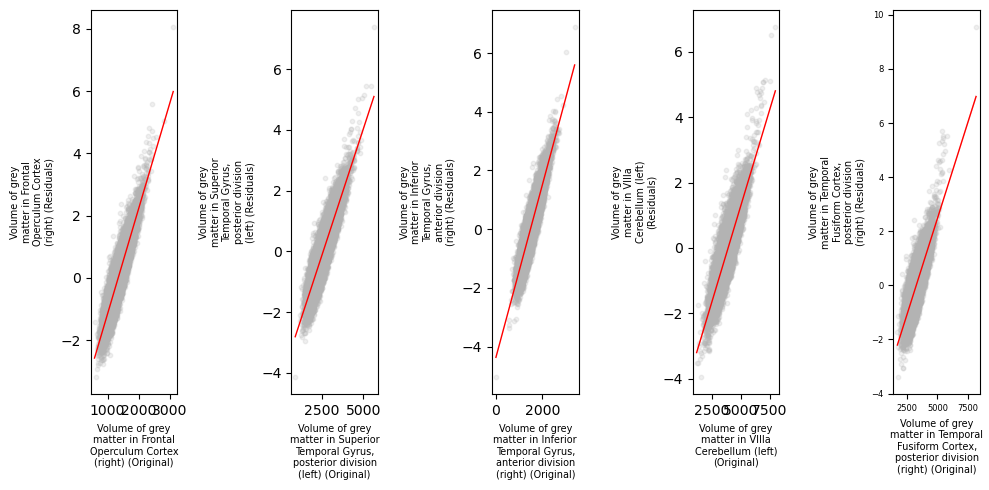

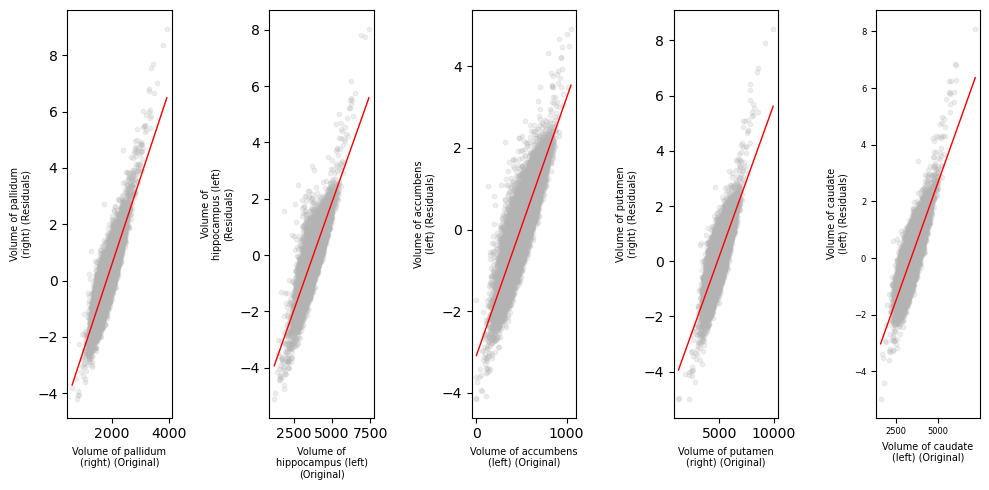

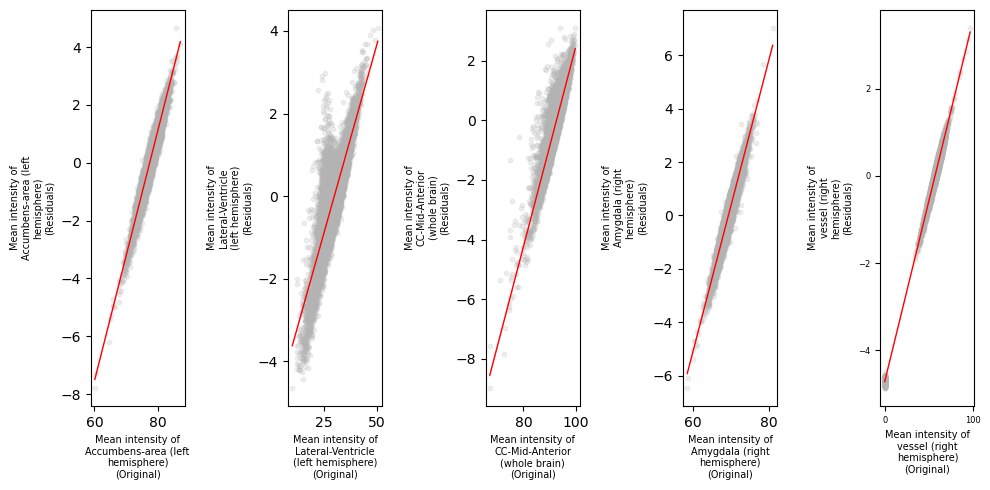

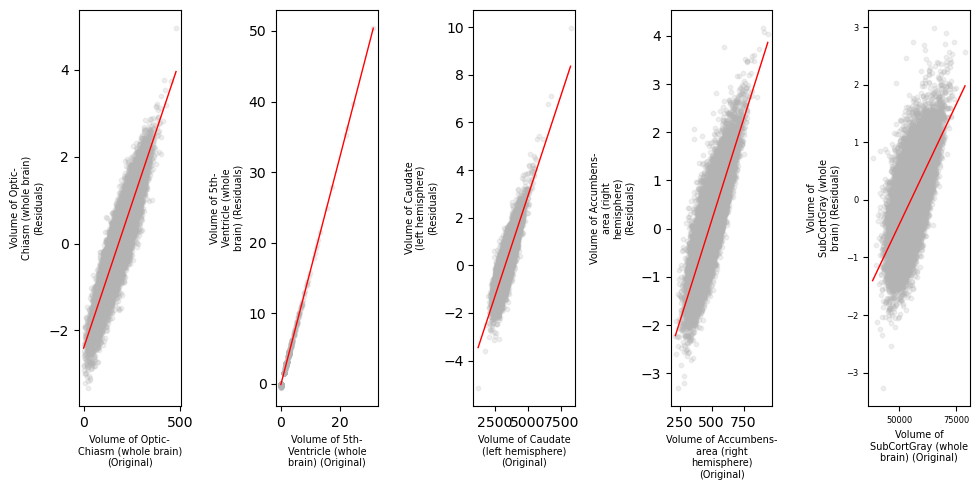

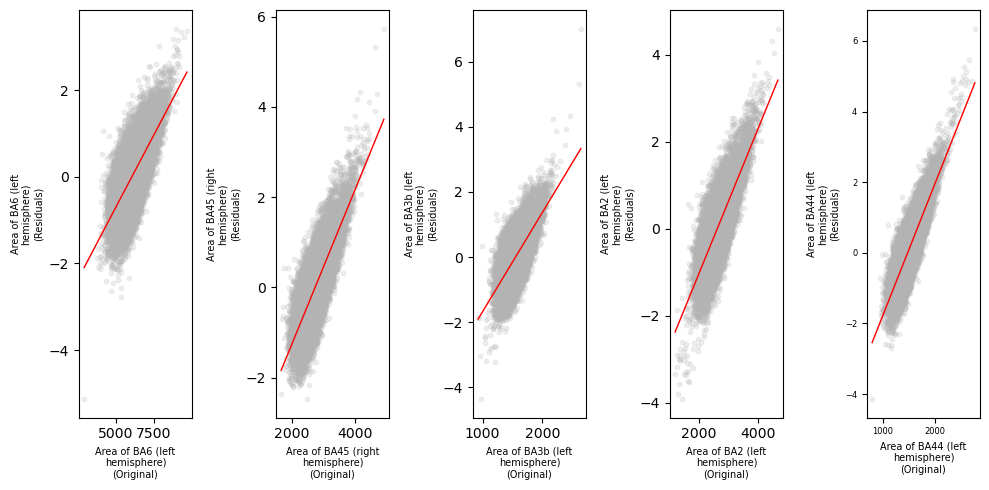

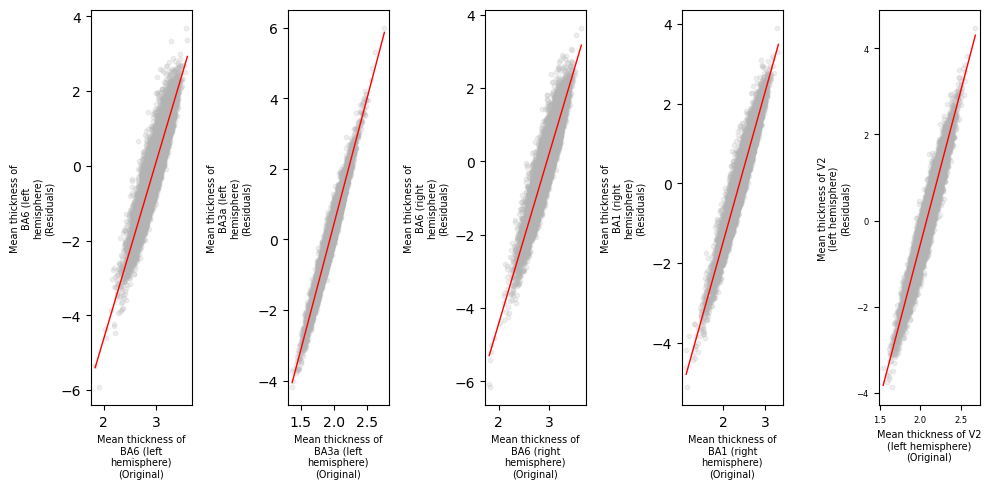

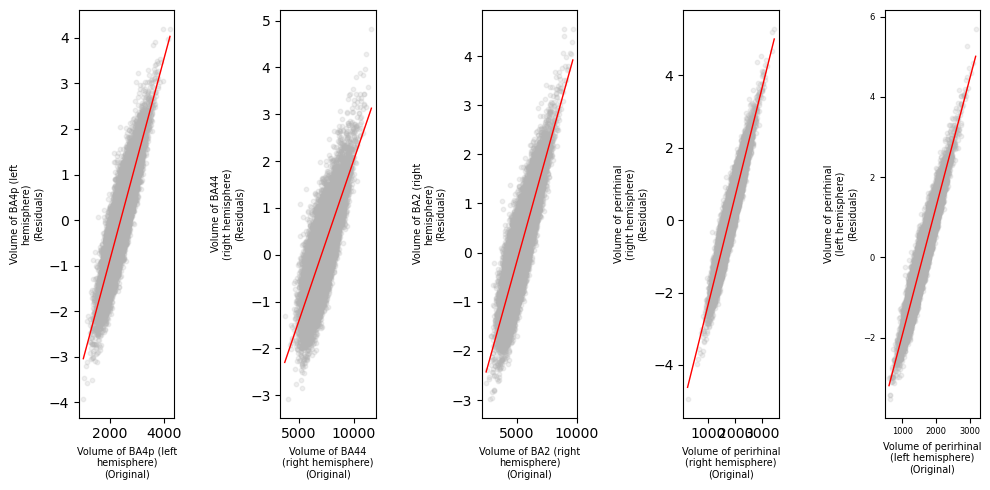

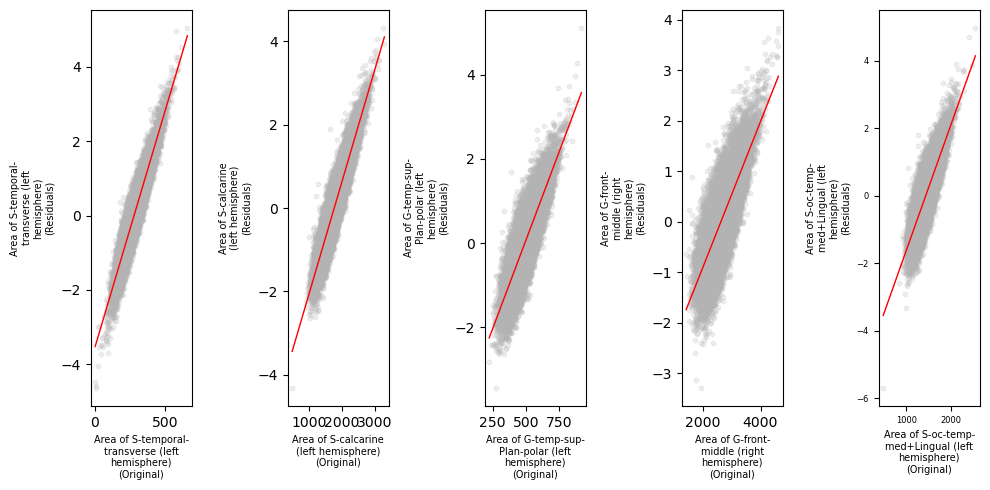

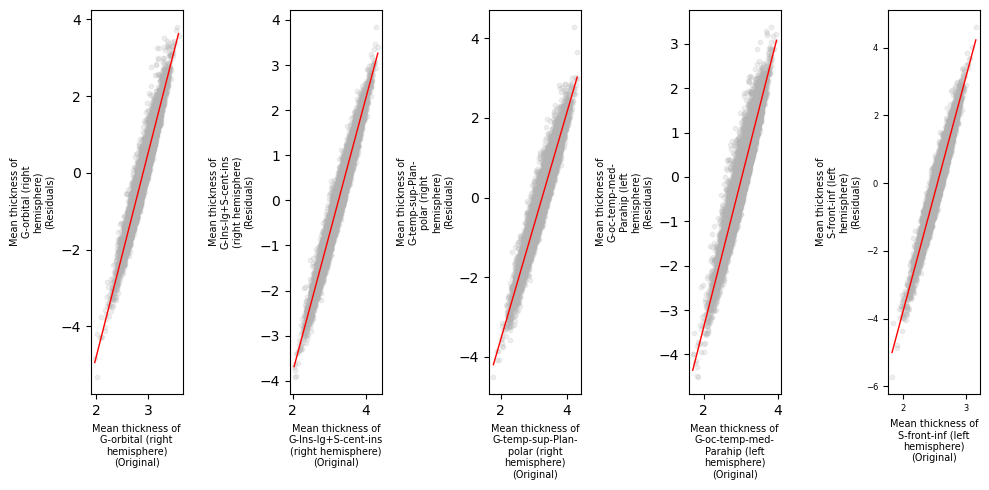

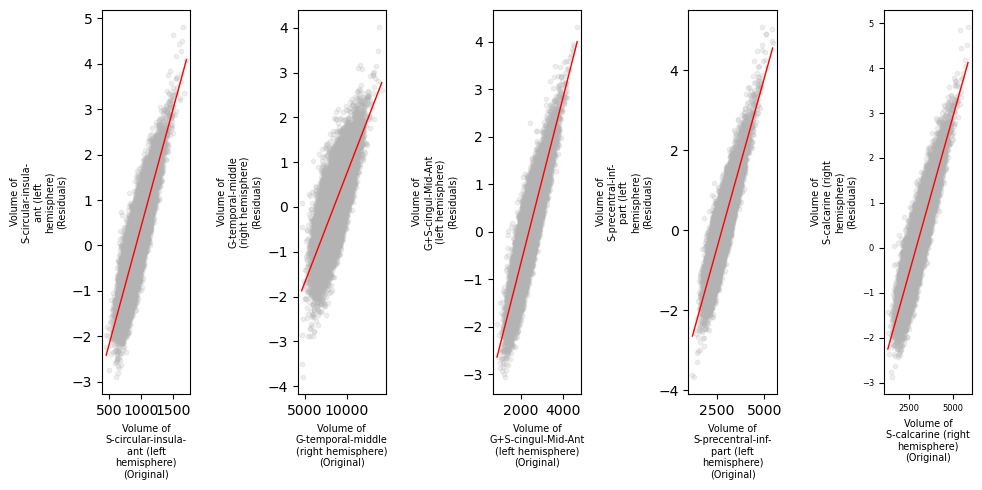

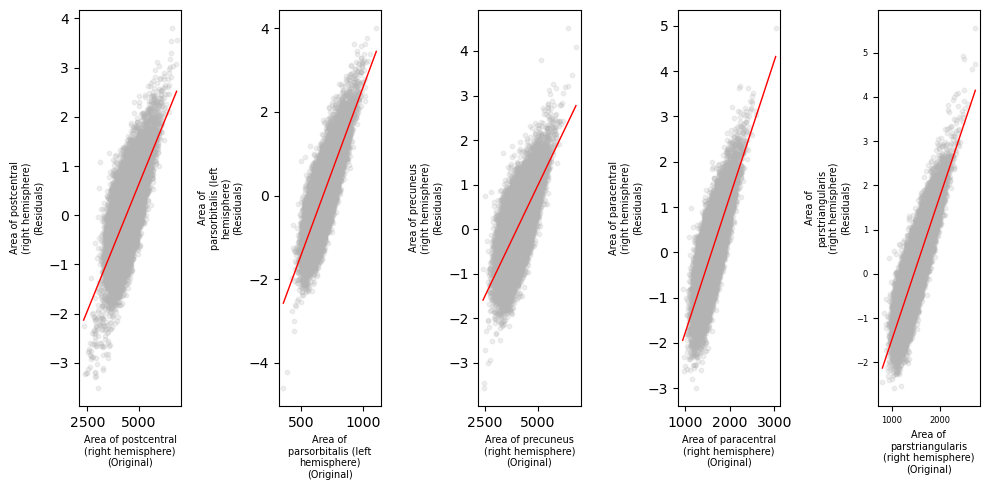

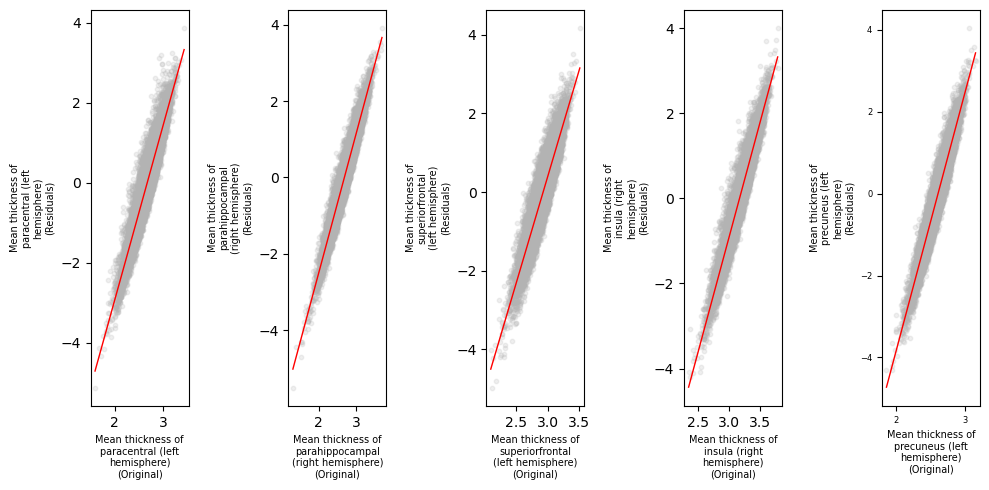

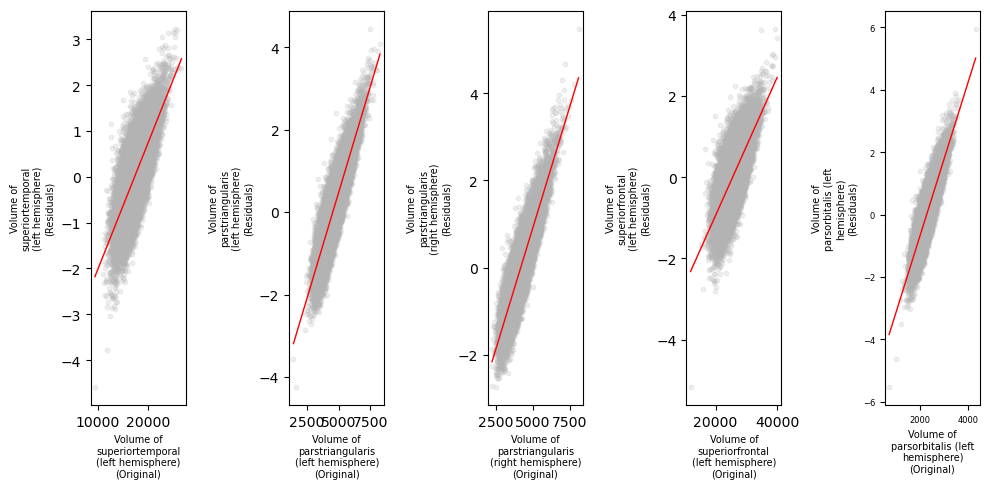

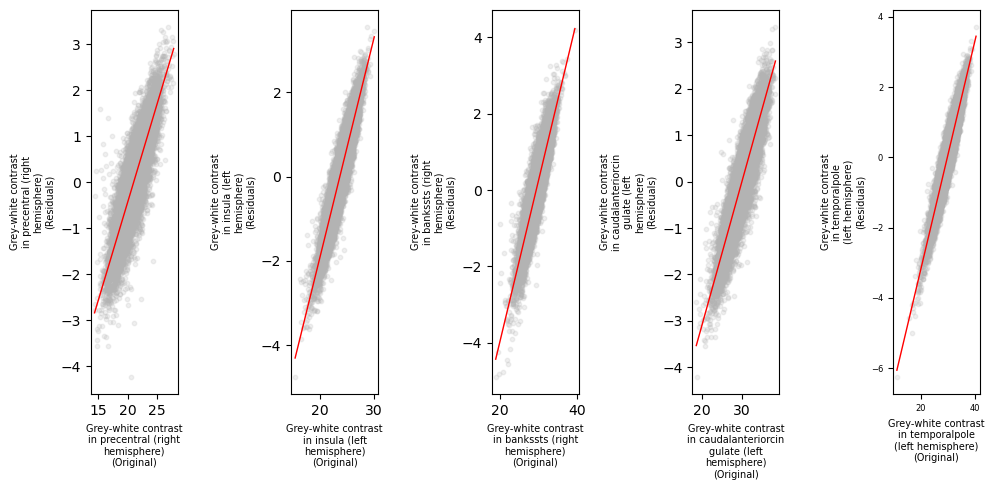

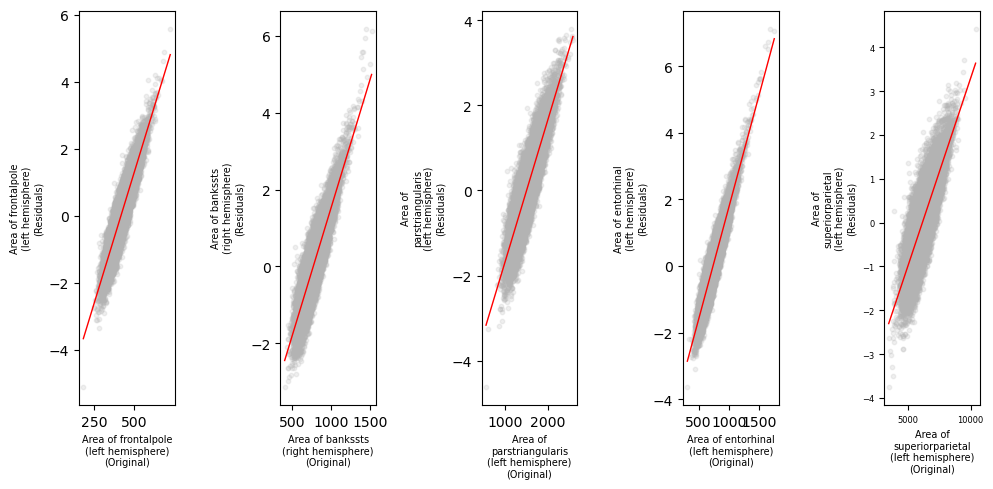

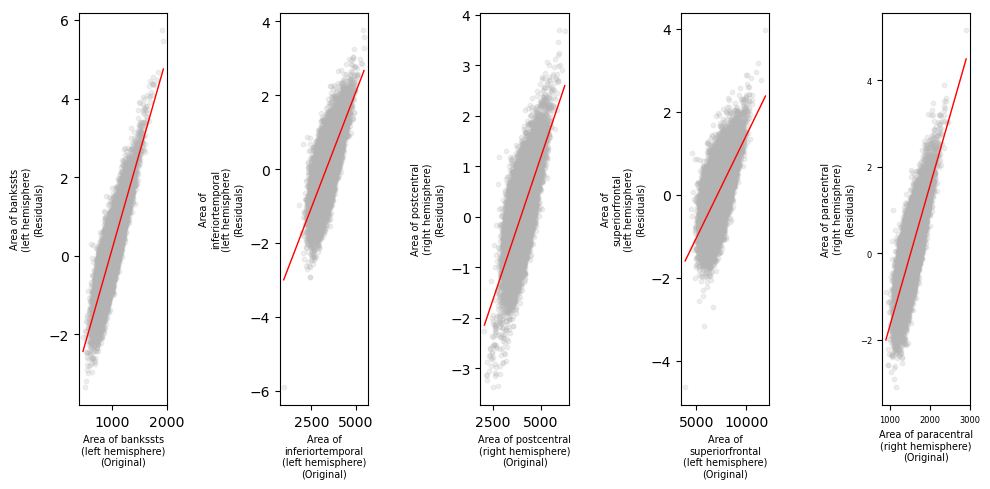

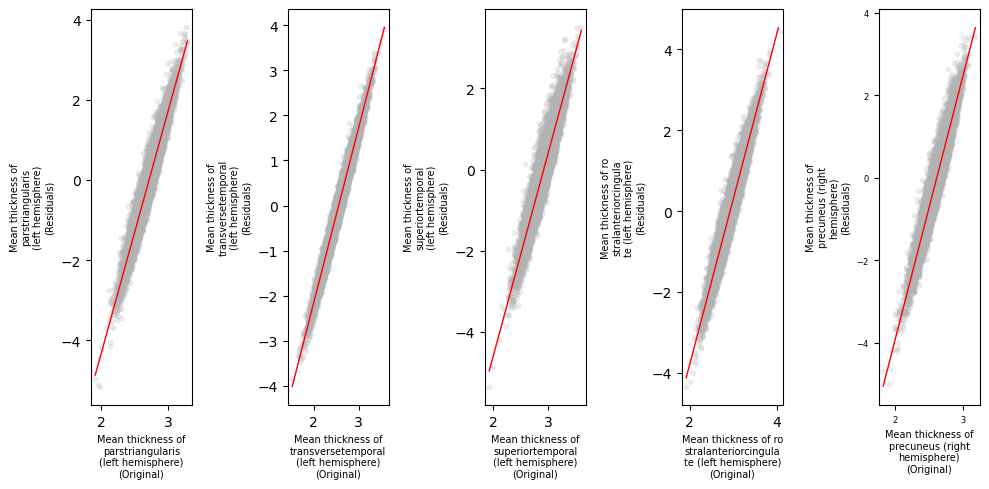

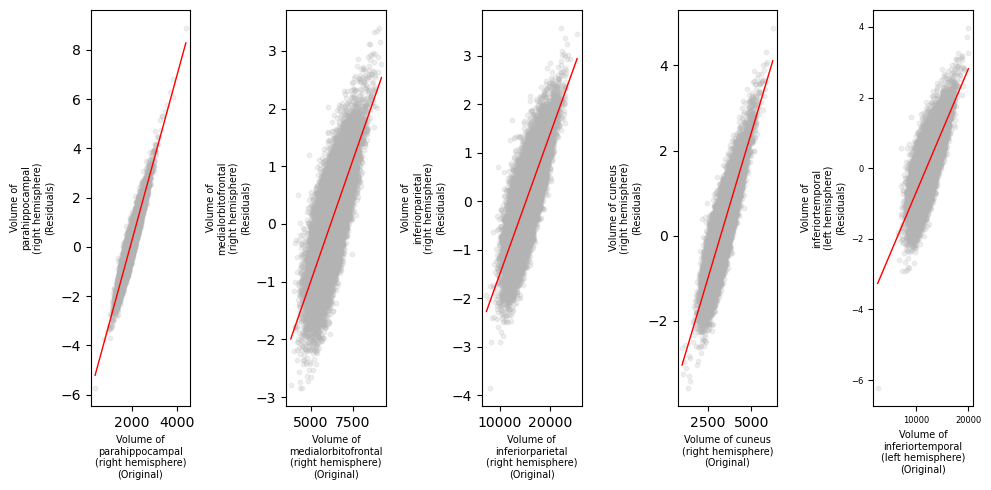

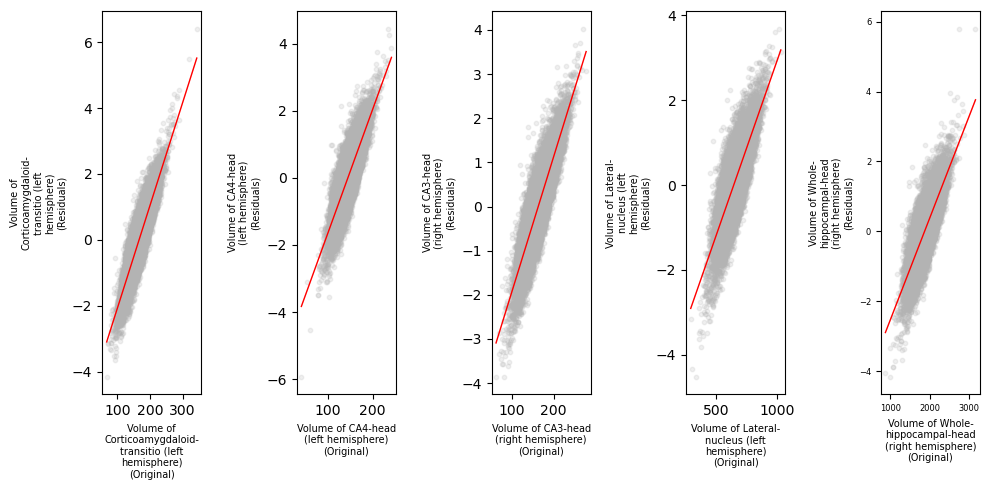

In [ ]:
plot_folds = ['0']
for modality in modalities:
    for fold in plot_folds:
        features_train_corr = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_corr_{fold}.csv')
        brain_train = pd.read_csv(f'/PLS/brain/t1/fold_{fold}/suppl/{modality}_train_fold_{fold}.csv')
        cols = brain_train.columns[:5]
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
        axes = axes.flatten()
        for i, col in enumerate(cols):
            sns.regplot(x=brain_train[col], y=features_train_corr[col], line_kws={'color': 'red', 'linewidth': 1}, scatter=True, scatter_kws = {"color": ".7", "s": 10, "alpha": 0.2}, ax=axes[i])
            axes[i].set_xlabel("\n".join(textwrap.wrap(cols[i] + ' (Original)', 20)), fontsize=7)
            axes[i].set_ylabel("\n".join(textwrap.wrap(cols[i] + ' (Residuals)', 20)), fontsize=7)
        plt.yticks(fontsize=6)
        plt.xticks(fontsize=6)
        plt.tight_layout()
        plt.show()